#多位点分析
#工作目录：D:\Postdoc\Projects\ESCC_TCR\TRUST\Trust4_vs_clinical_info

#https://omnideconv.org/immunedeconv/articles/detailed_example.html

In [3]:
library(dplyr)
library(ggplot2)
library(tidyr)
#library(immunedeconv)
library(tibble)
library(data.table)
library(reshape2)
library(pheatmap)
#library(msigdbr)
#library(fgsea)
library(cowplot)
library(patchwork)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 


载入程辑包：'patchwork'


The following object is masked from 'package:cowplot':

    align_plots




In [4]:
#IG类型比较
mypal <- ggsci::pal_npg(palette ="nrc", alpha = 0.7)(10)
mypal2<-ggsci::pal_jama(palette ="default", alpha = 0.7)(6)
mypal3<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.7)(9)
mypal4 <- ggsci::pal_npg(palette ="nrc", alpha = 0.5)(10)
mypal5<-ggsci::pal_jama(palette ="default", alpha = 0.5)(6)
mypal6<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.5)(9)
mypal7 <- ggsci::pal_npg(palette ="nrc", alpha = 0.3)(10)
mypal8<-ggsci::pal_jama(palette ="default", alpha = 0.3)(6)
mypal9<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.3)(9)

mypal<-c(mypal3,mypal2,mypal,mypal6,mypal5,mypal4,mypal9,mypal8,mypal7)
mypal[3]<-"#FFBD7A"


# 二、deconvolution结果生存分析

## 2.1 读取结果merge数据分析

### 2.1.1 读取Cibersort和MCP deconv结果

In [41]:
#mcp
res_mcp_counter_MR<-fread("MR_deconvolution_mcp_counter.new.csv") %>% as.data.frame()
MR_mcp_counter_out<-t(res_mcp_counter_MR[,-1])%>%as.data.frame()
colnames(MR_mcp_counter_out)<-paste("Mcp_counter.",res_mcp_counter_MR$cell_type,sep="")
MR_mcp_counter_out<-rownames_to_column(MR_mcp_counter_out,"ID")

#cibersort
MR_cibersort_out<-fread("MR_Cirbersot_out.new.txt")
colnames(MR_cibersort_out)[-1]<-paste("Cibersort.",colnames(MR_cibersort_out)[-1],sep="")

### 2.1.2 读取MR生存数据和基因表达数据merge

In [42]:
#survival
survival_data_orig<-fread("MR_survival_diversity.csv") 

#smoke drink
smoke_drink_info<-fread("MR_smoke_drink_info.csv")

#expr
data_multi<-fread("MR_expr_cibersort_input.new.txt")%>% as.data.frame()
data_multi_expr<-column_to_rownames(data_multi,var="GENE")

data_multi_mat<-t(data_multi_expr)
colnames(data_multi_mat)<-data_multi[,1]
MR_expr<-as.data.frame(data_multi_mat)
MR_expr<-rownames_to_column(MR_expr,var="ID")

dim(survival_data_orig)
dim(MR_expr)

[1] 651  51

[1]   654 60584

### 2.1.3 读取MR VJ usage

In [43]:
MR_VJ_usage<-fread("MR_VJ_usage.csv")
#MR_VJ_usage<-fread("MR_VJ_usage.allele.csv")

In [44]:
#1.merge suvival and expr
survival_data_orig<-merge(survival_data_orig,smoke_drink_info,by="Patient_ID")
survival_IGH_deversity_gene_expr<-merge(survival_data_orig,MR_expr,by="ID")

#add group col 
survival_IGH_deversity_gene_expr$group = substr(survival_IGH_deversity_gene_expr$type,1,1)

#2.merge VJ usage
survival_IGH_deversity_gene_expr<-merge(survival_IGH_deversity_gene_expr,MR_VJ_usage,by="ID")

#3.merge survival gene expr with 2 deconv
survival_IGH_deversity_gene_expr_deconv<-merge(survival_IGH_deversity_gene_expr,MR_cibersort_out,by="ID")
survival_IGH_deversity_gene_expr_deconv<-merge(survival_IGH_deversity_gene_expr_deconv,MR_mcp_counter_out,by="ID")

survival_IGH_deversity_gene_expr_deconv[1:5,1:5]
survival_IGH_deversity_gene_expr_deconv<-as.data.frame(survival_IGH_deversity_gene_expr_deconv)

ID,Patient_ID,Gender,Age,Location
<chr>,<chr>,<chr>,<int>,<chr>
ESCC001N,ESCC001,Male,60,Middle
ESCC001T1,ESCC001,Male,60,Middle
ESCC001T2,ESCC001,Male,60,Middle
ESCC001T3,ESCC001,Male,60,Middle
ESCC001T4,ESCC001,Male,60,Middle


In [45]:
survival_IGH_deversity_gene_expr_deconv$Smoking<-factor(survival_IGH_deversity_gene_expr_deconv$Smoking,levels=c("never","light","moderate","heavy"))
survival_IGH_deversity_gene_expr_deconv$Drinking<-factor(survival_IGH_deversity_gene_expr_deconv$Drinking,levels=c("never","light","moderate","heavy"))

#### 更改s_richness等feature为sequence.richness

In [46]:
rname_col<-gsub(colnames(survival_IGH_deversity_gene_expr_deconv),pattern ="s_richness_",replacement = "sequence.richness.")
rname_col<-gsub(rname_col,pattern ="_proportion_redundant",replacement = ".sequence.proportion")

In [47]:
colnames(survival_IGH_deversity_gene_expr_deconv)<-rname_col

In [220]:
write.csv(survival_IGH_deversity_gene_expr_deconv,"survival_IGH_deversity_gene_expr_deconv.csv",row.names=FALSE,quote=FALSE)

## 2.2 生存分析

### 2.2.1 准备数据预处理

In [5]:
survival_IGH_deversity_gene_expr_deconv<-read.csv("survival_IGH_deversity_gene_expr_deconv.csv",header=TRUE,check.names=FALSE)


In [55]:

## 筛选TNL数据
T_data<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]
N_data<-survival_IGH_deversity_gene_expr_deconv[grep("N",survival_IGH_deversity_gene_expr_deconv$type),]
L_data<-survival_IGH_deversity_gene_expr_deconv[grep("L",survival_IGH_deversity_gene_expr_deconv$type),]

In [60]:
table(survival_IGH_deversity_gene_expr_deconv$Smoking)
table(survival_IGH_deversity_gene_expr_deconv$Drinking)


   never    light moderate    heavy 
     333       27       86      201 


   never    light moderate    heavy 
     428       77       64       78 

#### 每个样本IGH richness作为独立病人做分析

In [18]:
survival_data<-T_data

unique(survival_data$TNM)

diversity_features<-c('s_richness','s_shannon',
    'sequence.richness.IGHM',
    'sequence.richness.IGHD',
    'sequence.richness.IGHA1','sequence.richness.IGHA2',
    'sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4',
    'sequence.richness.IGHE'
    )

dim(survival_data)

survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"ⅡII"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"ⅢIII"#,"\u2162" # Ⅲ
survival_data$TNM_flag[survival_data$TNM %in% c("IVa")]<-"ⅣIV"#"\u2163" # Ⅳ

#survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))

# survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"I & II"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
# survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa","IVa")]<-"III & IV"#,"\u2162" # Ⅲ

survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

survival_data$Location[survival_data$Location=="Upper&Lower"]="Upper"

survival_data$Age_flag[survival_data$Age>=60]<-"older(>=60)"
survival_data$Age_flag[survival_data$Age<60]<-"younger"
survival_data$Age_flag<-factor(survival_data$Age_flag,levels=c("younger","older(>=60)"))

survival_data$Smoking<-factor(survival_data$Smoking,levels=c("never","light","moderate","heavy"))
survival_data$Drinking<-factor(survival_data$Drinking,levels=c("never","light","moderate","heavy"))

survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))

selected_cols<-colnames(survival_data) %in% c("Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag",diversity_features)
survival_data<-survival_data[,selected_cols]


[1] "Ⅱb"   "Ⅱa"   "Ⅲa"   "Ⅲc"   "IIa"  "Ⅲb"   "IIIb" "IIb"  "IIIa" "IVa"

[1]   492 60728

## 3.1 IGHG1

### 3.1.1 计算IGHG高相关基因,读取时间长，可跳过，直接读取表格

In [19]:
#1.T中与IGHG1_richness高相关的基因
IGHG_richness<-T_data$sequence.richness.IGHG1

high_cor_genes_T<-data.frame("GeneSymbol"=NA,"Rho"=NA,"p_value"=NA)
n=1
for(g in colnames(MR_expr)[-1]){
    if(sum(T_data[,g])==0){next}
    cor_result<-cor.test(IGHG_richness,T_data[,g],method="spearman",exact=FALSE)
    
    #if(abs(cor_result$estimate)>0.7){
        high_cor_genes_T[n,1]<-g
        high_cor_genes_T[n,2]<-cor_result$estimate
        high_cor_genes_T[n,3]<-cor_result$p.value
        n=n+1
    #}
}

#high_cor_genes_T<-high_cor_genes_T[-grep("IG",high_cor_genes_T$GeneSymbol),]
high_cor_genes_T<-high_cor_genes_T[order(high_cor_genes_T$Rho,decreasing=TRUE),]


#2.N中与IGHG1_richness高相关的基因
IGHG_richness<-N_data$sequence.richness.IGHG1

high_cor_genes_N<-data.frame("GeneSymbol"=NA,"Rho"=NA,"p_value"=NA)
n=1
for(g in colnames(MR_expr)[-1]){
    if(sum(N_data[,g])==0){next}
    cor_result<-cor.test(IGHG_richness,N_data[,g],method="spearman",exact=FALSE)
    
#    if(abs(cor_result$estimate)>0.7){
        high_cor_genes_N[n,1]<-g
        high_cor_genes_N[n,2]<-cor_result$estimate
        high_cor_genes_N[n,3]<-cor_result$p.value
        n=n+1
#    }
}

#high_cor_genes_N<-high_cor_genes_N[-grep("IG",high_cor_genes_N$GeneSymbol),]
high_cor_genes_N<-high_cor_genes_N[order(high_cor_genes_N$Rho,decreasing=TRUE),]
#3.L中与IGHG1_richness高相关的基因

IGHG_richness<-L_data$sequence.richness.IGHG1

high_cor_genes_L<-data.frame("GeneSymbol"=NA,"Rho"=NA,"p_value"=NA)
n=1
for(g in colnames(MR_expr)[-1]){
    if(sum(L_data[,g])==0){next}
    cor_result<-cor.test(IGHG_richness,L_data[,g],method="spearman",exact=FALSE)
    
#    if(abs(cor_result$estimate)>0.7){
        high_cor_genes_L[n,1]<-g
        high_cor_genes_L[n,2]<-cor_result$estimate
        high_cor_genes_L[n,3]<-cor_result$p.value
        n=n+1
#    }
}

#high_cor_genes_N<-high_cor_genes_N[-grep("IG",high_cor_genes_N$GeneSymbol),]
high_cor_genes_L<-high_cor_genes_L[order(high_cor_genes_L$Rho,decreasing=TRUE),]
high_cor_genes_T$type="T"
high_cor_genes_N$type="N"
high_cor_genes_L$type="L"
high_cor_genes<-rbind(high_cor_genes_T,high_cor_genes_N,high_cor_genes_L)

write.csv(high_cor_genes,"high_cor_genes_IGHG1_richness_TNL.csv",row.names=FALSE,quote=FALSE)

### 3.1.2 读取IGHG1高相关基因

In [25]:
write.csv(high_cor_genes,"Fig4A.csv",quote=FALSE,row.names=FALSE)

In [20]:
high_cor_genes<-read.csv("high_cor_genes_IGHG1_richness_TNL.csv",header=TRUE)

#筛选去除TR/IG基因
receptor_genes_index<-c(grep("^TRB",high_cor_genes$GeneSymbol),
grep("^TRA",high_cor_genes$GeneSymbol),
grep("^IGH",high_cor_genes$GeneSymbol),
grep("^IGL",high_cor_genes$GeneSymbol),
grep("^IGK",high_cor_genes$GeneSymbol))

high_cor_genes<-high_cor_genes[-receptor_genes_index,]
head(high_cor_genes)

high_cor_genes_T<-high_cor_genes[high_cor_genes$type=="T",]
high_cor_genes_N<-high_cor_genes[high_cor_genes$type=="N",]
high_cor_genes_L<-high_cor_genes[high_cor_genes$type=="L",]

,GeneSymbol,Rho,p_value,type
,<chr>,<dbl>,<dbl>,<chr>
5,MZB1,0.9096437,4.372530e-189,T
6,FCRL5,0.9001507,5.555353e-179,T
13,ANKRD36BP2,0.8854427,3.516041e-165,T
20,CD79A,0.8522233,5.808247e-140,T
21,TENT5C,0.8515280,1.674677e-139,T
29,LAX1,0.8390867,1.188541e-131,T


## 3.3 分析与IGHG richness高度正相关和负相关的基因，筛选肿瘤特异性的

### 3.3.1 NTL中与IGHG1_richness正相关的基因,筛选前500个T特异性的正相关基因

In [21]:
T_high<-high_cor_genes_T[1:500,]$GeneSymbol

N_high<-high_cor_genes_N[1:1000,]$GeneSymbol

#L_high<-high_cor_genes_L[1:1000,]$GeneSymbol

length(T_high)
length(N_high)
T_specific_genes<-T_high[!T_high %in% N_high] 
T_high<-high_cor_genes_T[high_cor_genes_T$GeneSymbol %in% T_specific_genes,]

T_high$p_adj<-p.adjust(T_high$p_value,method="BH")
row.names(T_high)<-NULL
T_high[1:20,-4]

dim(T_high)

#write.csv(T_high[1:20,-4],"T_high_cor_with_IGHG1_genes_top20.csv",row.names=FALSE,quote=FALSE)

[1] 500

[1] 1000

,GeneSymbol,Rho,p_value,p_adj
,<chr>,<dbl>,<dbl>,<dbl>
1,AMPD1,0.7191198,1.724550e-79,2.897243e-77
2,DCC,0.6716175,8.129828e-66,6.829056e-64
3,TNFRSF17,0.6437749,6.317309e-59,3.537693e-57
4,KCNN3,0.6353024,5.720583e-57,2.402645e-55
5,IL5RA,0.6296514,1.069070e-55,3.592075e-54
6,AC012236.1,0.6198787,1.469151e-53,4.113624e-52
7,BHLHA15,0.5907247,1.312796e-47,3.150711e-46
8,HERPUD1,0.5882225,3.990679e-47,8.380426e-46
9,P2RX1,0.5871073,6.529688e-47,1.218875e-45


[1] 168   5

# Fig4 A

### 3.3.2 韦恩图特异性基因

[1] TRUE

null device 
          1

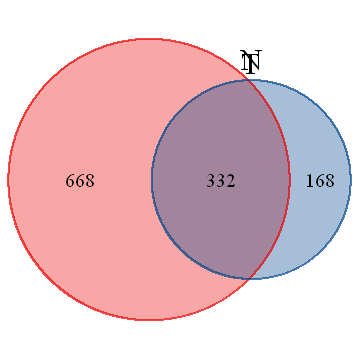

In [27]:
library(VennDiagram)

T_high_gene<-high_cor_genes_T[1:500,]$GeneSymbol

N_high_gene<-high_cor_genes_N[1:1000,]$GeneSymbol

options(repr.plot.width = 3, repr.plot.height = 3)
gene_list1 <- list(T = T_high_gene,N=N_high_gene)
                         
venn.plot = venn.diagram(gene_list1, filename = NULL,ext.text = F,
                         fill = c('#00468BB2','#ED0000B2'),
                         col = c('#00468BB2','#ED0000B2'),#brewer.pal(8, "Set1"),
                         lwd = 2, #lty = "dashed",
                         cat.default.pos = "outer",
                         cat.cex = 1.5,
                         cat.pos = c(180, 220)
                         )
grid.draw(venn.plot)
file.remove(list.files(pattern = "*log"))
dev.off()


### 3.3.3 NTL中与IGHG1_richness负相关的基因,筛选前250个T特异性的负相关基因

In [28]:
T_low<-high_cor_genes_T[(nrow(high_cor_genes_T)-199):nrow(high_cor_genes_T),]$GeneSymbol

N_low<-high_cor_genes_N[(nrow(high_cor_genes_N)-399):nrow(high_cor_genes_N),]$GeneSymbol

#T_low<-high_cor_genes_T[(nrow(high_cor_genes_T)-499):nrow(high_cor_genes_T),]$GeneSymbol

#N_low<-high_cor_genes_N[(nrow(high_cor_genes_N)-999):nrow(high_cor_genes_N),]$GeneSymbol

length(T_low)
length(N_low)
T_specific_genes_low<-T_low[!T_low %in% N_low] 

T_low<-high_cor_genes_T[high_cor_genes_T$GeneSymbol %in% T_specific_genes_low,]

T_low<-T_low[ordered(T_low$Rho),]

T_low$p_adj<-p.adjust(T_low$p_value,method="BH")
row.names(T_low)<-NULL

T_low[1:20,-4]
#write.csv(T_low[1:20,-4],"T_low_cor_with_IGHG3_genes_top20.csv",row.names=FALSE,quote=FALSE)
#write.csv(T_low,"T_low_cor_with_IGHG1_genes.csv",row.names=FALSE,quote=FALSE)

[1] 200

[1] 400

,GeneSymbol,Rho,p_value,p_adj
,<chr>,<dbl>,<dbl>,<dbl>
1,ACTN1,-0.3548188,4.826167e-16,8.349269e-14
2,INF2,-0.3293686,6.510897e-14,5.631926e-12
3,AGPAT4,-0.3203872,3.307049e-13,1.907065e-11
4,ARHGEF10,-0.3064730,3.691697e-12,1.596659e-10
5,TPD52L2,-0.3025256,7.154233e-12,2.475365e-10
6,SPIRE1,-0.3003751,1.021581e-11,2.633142e-10
7,STK19,-0.3001202,1.065433e-11,2.633142e-10
8,SNORA73B,-0.2942858,2.757124e-11,5.626021e-10
9,FADS3,-0.2934975,3.129948e-11,5.626021e-10


[1] TRUE

null device 
          1

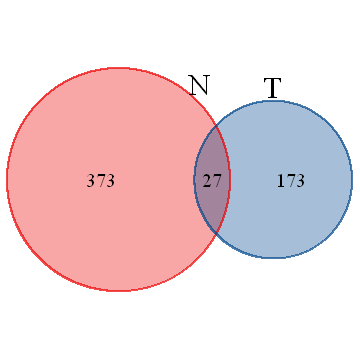

In [29]:
library(VennDiagram)

T_high_gene<-high_cor_genes_T[(nrow(high_cor_genes_T)-199):nrow(high_cor_genes_T),]$GeneSymbol

N_high_gene<-high_cor_genes_N[(nrow(high_cor_genes_N)-399):nrow(high_cor_genes_N),]$GeneSymbol


options(repr.plot.width = 3, repr.plot.height = 3)
gene_list1 <- list(T = T_high_gene,N=N_high_gene)
                         
venn.plot = venn.diagram(gene_list1, filename = NULL,ext.text = F,
                         fill = c('#00468BB2','#ED0000B2'),
                         col = c('#00468BB2','#ED0000B2'),#brewer.pal(8, "Set1"),
                         lwd = 2, #lty = "dashed",
                         cat.default.pos = "outer",
                         cat.cex = 1.5,
                         cat.pos = c(180, 220)
                         )
grid.draw(venn.plot)
file.remove(list.files(pattern = "*log"))
dev.off()


In [ ]:
write.csv(MR_high_cor_pos_neg,"MR_high_cor_IGHG1_pos_neg.csv",row.names=FALSE,quote=FALSE)

In [30]:
write.csv(MR_high_cor_pos_neg,"Fig4AEFGH.csv",quote=FALSE,row.names=FALSE)

ERROR: Error in is.data.frame(x): 找不到对象'MR_high_cor_pos_neg'


### 3.3.5 对筛选到的基因进行Go和KEGG分析

In [21]:
library(ggplot2)
library(ggrepel)

筛选出的肿瘤中IGHG1_richness高相关性的基因富集分析

In [70]:
library(org.Hs.eg.db) #人类注释数据库
library(clusterProfiler)#进行GO富集和KEGG富集

x<-T_high$GeneSymbol
hg<-bitr(x,fromType="SYMBOL",toType=c("ENTREZID","ENSEMBL","SYMBOL"),OrgDb="org.Hs.eg.db")
hg<-hg[!duplicated(hg$ENTREZID),]

go_pos <- enrichGO(hg$ENTREZID,OrgDb = org.Hs.eg.db, ont='ALL',pAdjustMethod = 'BH',pvalueCutoff = 0.05, qvalueCutoff = 0.2,keyType = 'ENTREZID')


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL", :
"7.74% of input gene IDs are fail to map..."


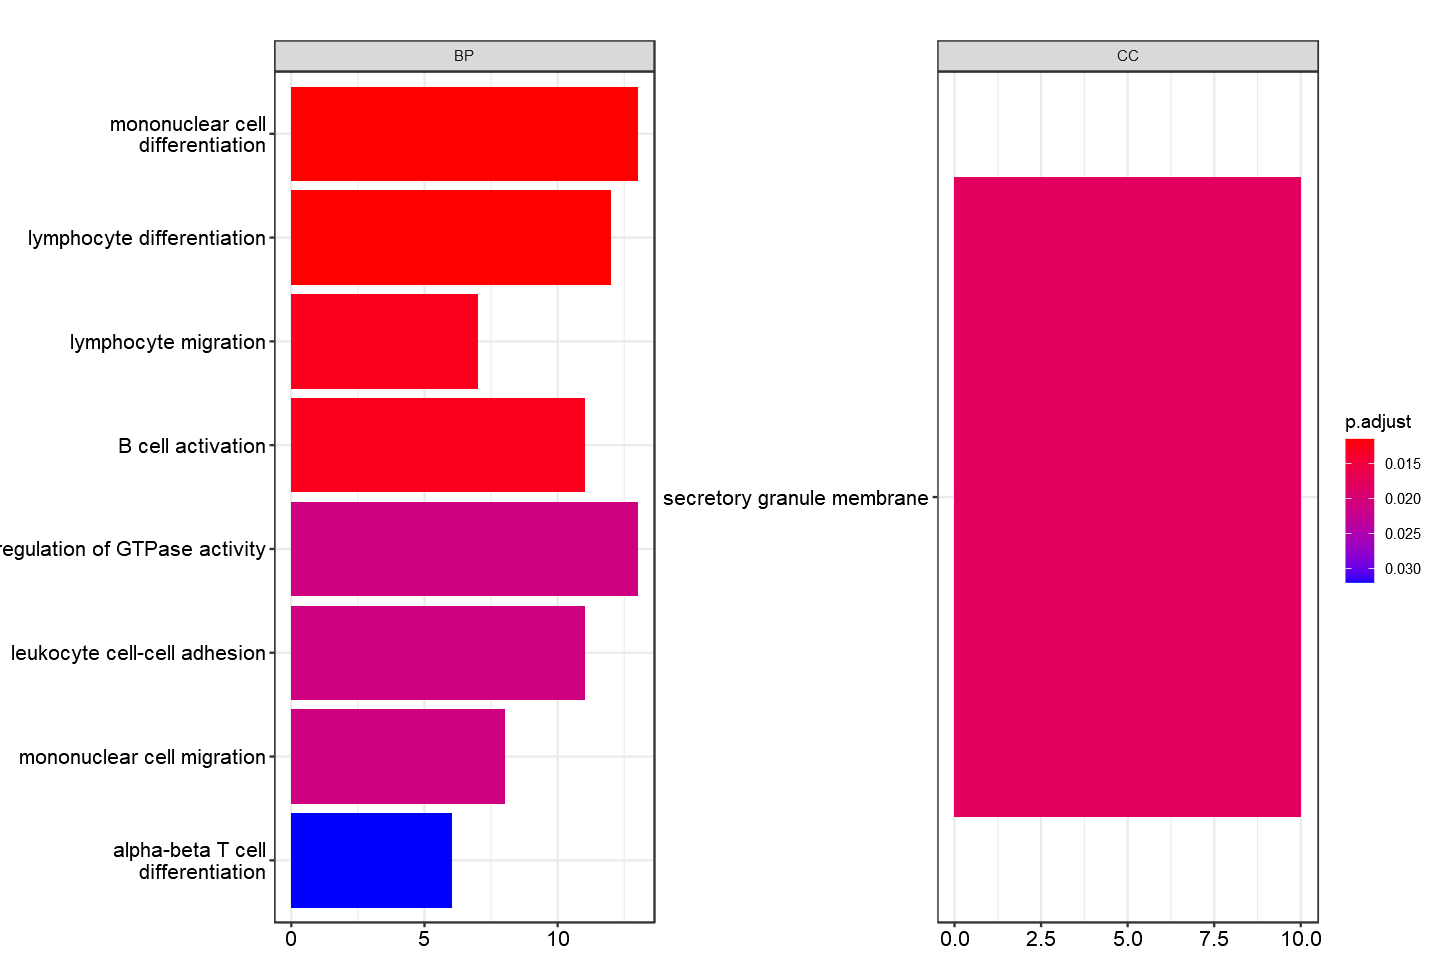

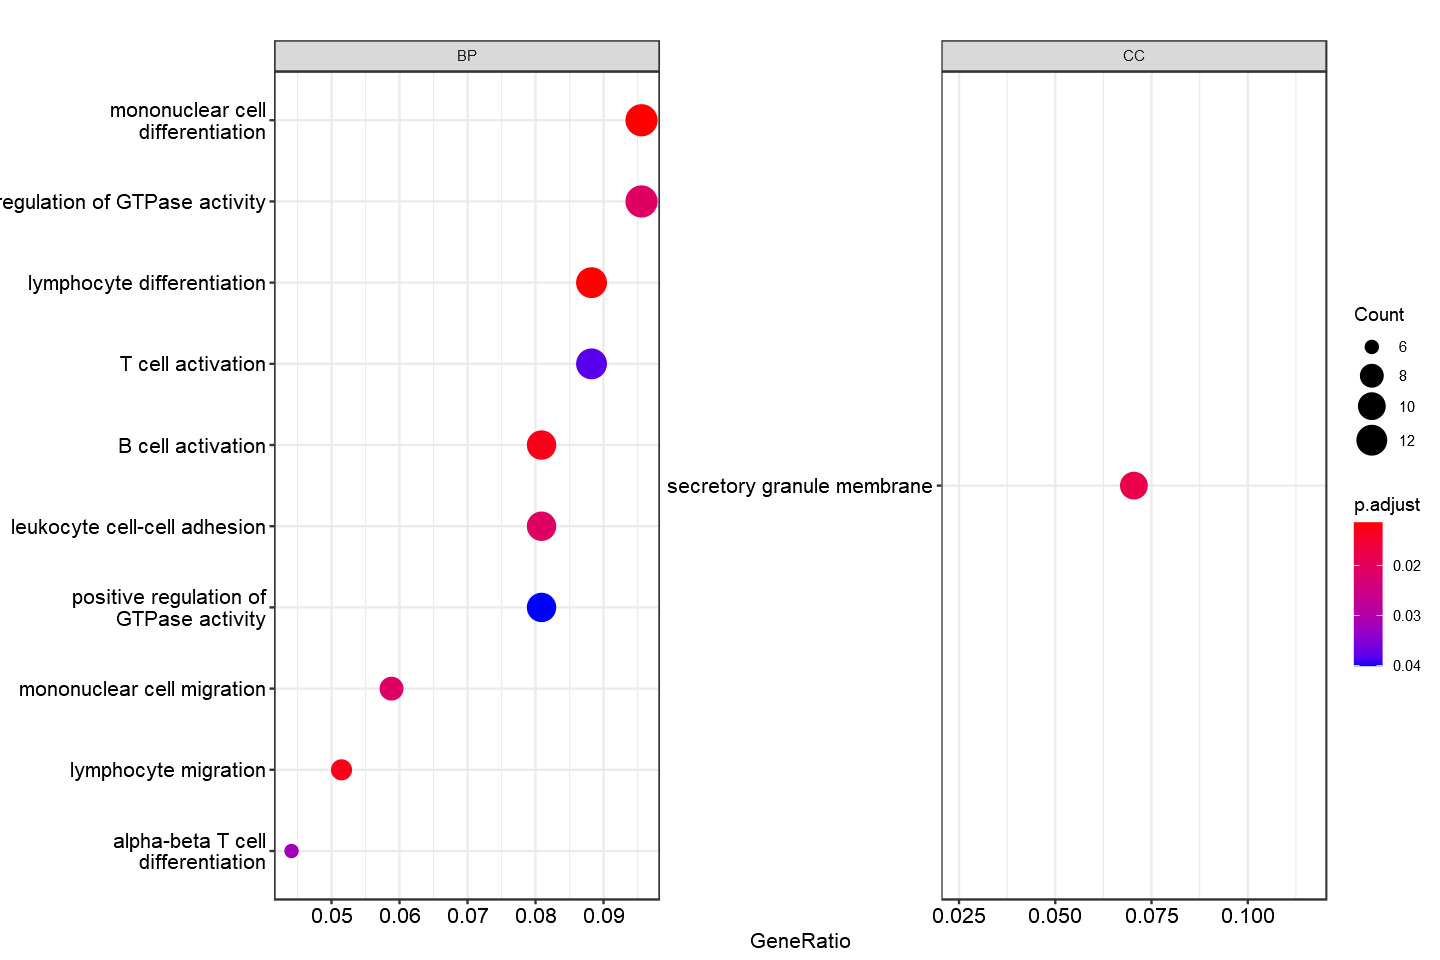

In [72]:
options(repr.plot.width = 12, repr.plot.height = 8)
#GO
#barplot(go_pos,showCategory=20,drop=T)#柱状图
#dotplot(go_pos,showCategory=20)#柱状图
barplot(go_pos, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")
dotplot(go_pos, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")

g_pos_go<-dotplot(go_pos, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")
#emapplot(go)



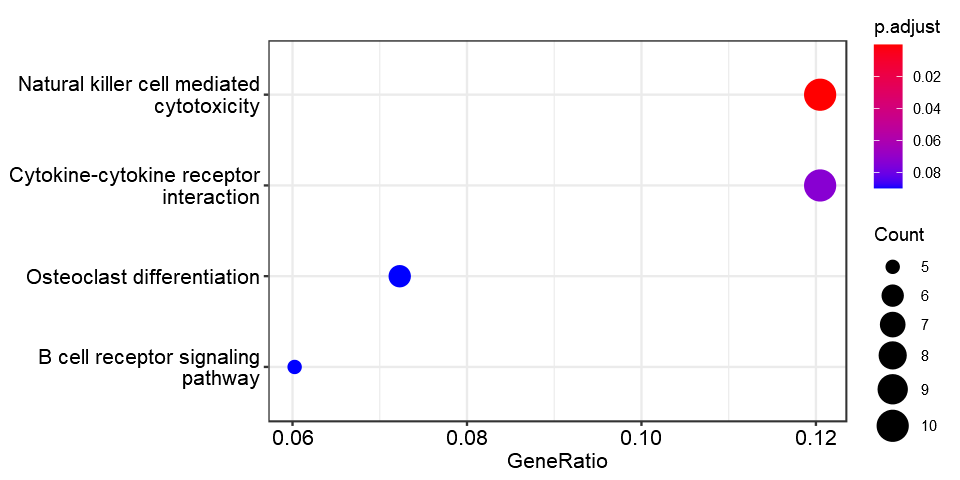

In [60]:
options(repr.plot.width = 8, repr.plot.height = 4)
#KEGG
R.utils::setOption("clusterProfiler.download.method",'auto')
#########
kegg <- enrichKEGG(hg$ENTREZID, organism = 'hsa', keyType = 'kegg', 
                   pvalueCutoff = 0.1, pAdjustMethod = 'BH',
                   minGSSize = 3, maxGSSize = 500, qvalueCutoff = 0.2, 
                   use_internal_data = FALSE)#进行KEGG富集
#g_pos_kegg<-barplot(kegg,showCategory=10)
g_pos_kegg<-dotplot(kegg,showCategory=10)

#查看富集到该通路的基因有哪些
#kegg_ENTREZID<-strsplit(kegg$geneID,"/") %>% unlist()
#kegg_SYMBOL<-hg$SYMBOL[hg$ENTREZID %in% kegg_ENTREZID]
#T_high[T_high$GeneSymbol %in% kegg_SYMBOL,]

#查看富集到的基因
#browseKEGG(kegg, "hsa04380")



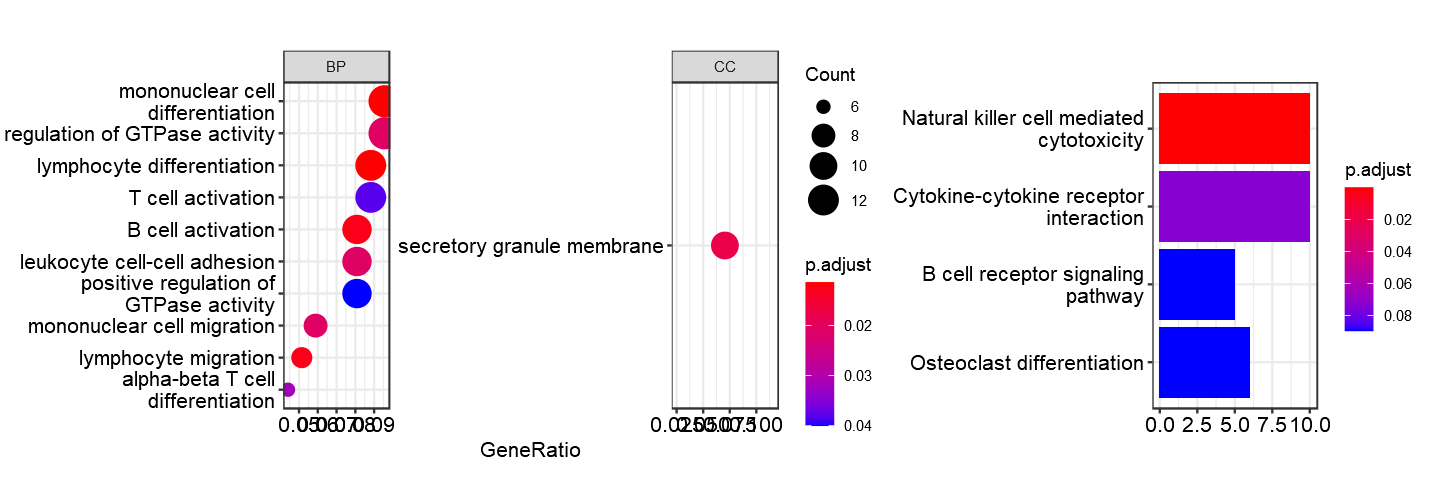

In [77]:
library(patchwork)
options(repr.plot.width = 12, repr.plot.height =4)
g_pos<-g_pos_go+g_pos_kegg+plot_layout(nrow=1,widths=c(3,1))

In [86]:
library(org.Hs.eg.db) #人类注释数据库
library(clusterProfiler)#进行GO富集和KEGG富集

x<-T_low$GeneSymbol
hg<-bitr(x,fromType="SYMBOL",toType=c("ENTREZID","ENSEMBL","SYMBOL"),OrgDb="org.Hs.eg.db")
hg<-hg[!duplicated(hg$ENTREZID),]

go_neg <- enrichGO(hg$ENTREZID,OrgDb = org.Hs.eg.db, ont='ALL',pAdjustMethod = 'BH',pvalueCutoff = 0.05, qvalueCutoff = 0.2,keyType = 'ENTREZID')


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL", :
"3.47% of input gene IDs are fail to map..."


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

#GO
#barplot(go,showCategory=10,drop=T)#柱状图
#g_neg_go<-dotplot(go,showCategory=10)#柱状图
barplot(go_neg, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")
dotplot(go_neg, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")

g_neg_go<-dotplot(go_neg, split="ONTOLOGY")+ facet_wrap(.~ONTOLOGY,scale="free")

,GeneSymbol,Rho,p_value,type,p_adj
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
16,RPS6KA4,-0.2824465,1.78e-10,T,1.864556e-09
22,MAP3K20,-0.2723035,8.20e-10,T,6.047792e-09
28,NGF,-0.2698427,1.18e-09,T,7.290714e-09
59,GNA12,-0.2381690,8.97e-08,T,2.609180e-07
69,VEGFA,-0.2321207,1.92e-07,T,4.813913e-07
80,FLNB,-0.2267364,3.72e-07,T,8.044500e-07
82,FLNA,-0.2249702,4.60e-07,T,9.704878e-07
94,PDGFA,-0.2209559,7.43e-07,T,1.367436e-06
95,IL1RAP,-0.2204010,7.93e-07,T,1.444095e-06


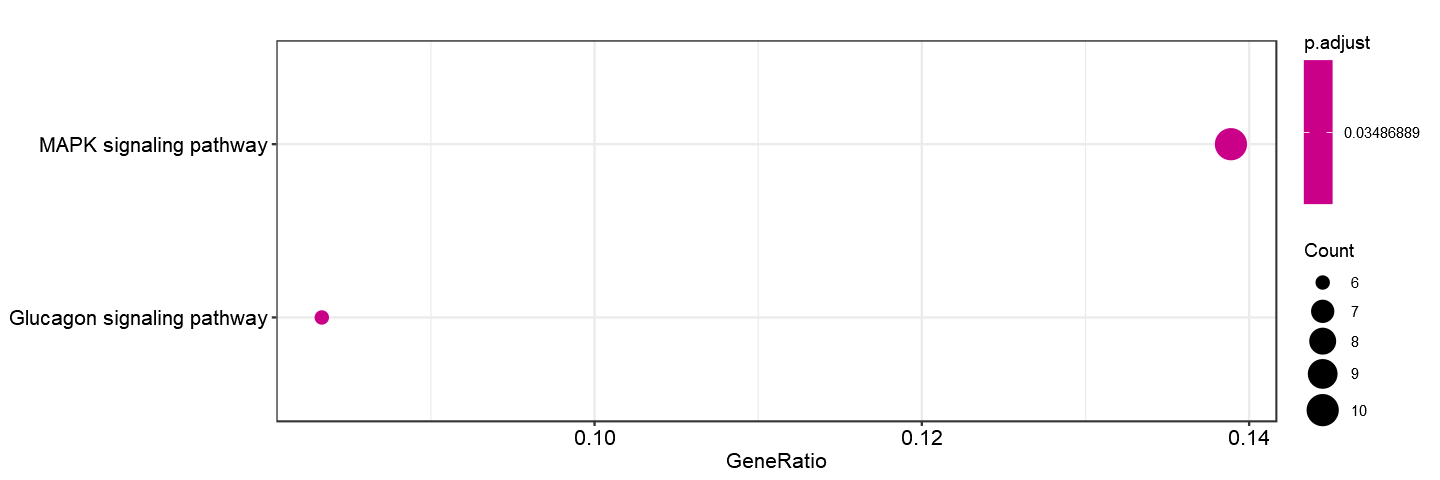

In [83]:

#KEGG
R.utils::setOption("clusterProfiler.download.method",'auto')
#########
kegg <- enrichKEGG(hg$ENTREZID, organism = 'hsa', keyType = 'kegg', 
                   pvalueCutoff = 0.05, pAdjustMethod = 'BH',
                   minGSSize = 3, maxGSSize = 500, qvalueCutoff = 0.2, 
                   use_internal_data = FALSE)#进行KEGG富集
                   
g_neg_kegg<-barplot(kegg,showCategory=20)
dotplot(kegg,showCategory=20)

kegg_ENTREZID<-strsplit(kegg$geneID[[1]],"/") %>% unlist()
kegg_SYMBOL<-hg$SYMBOL[hg$ENTREZID %in% kegg_ENTREZID]
T_low[T_low$GeneSymbol %in% kegg_SYMBOL,]

# Fig4 E-H

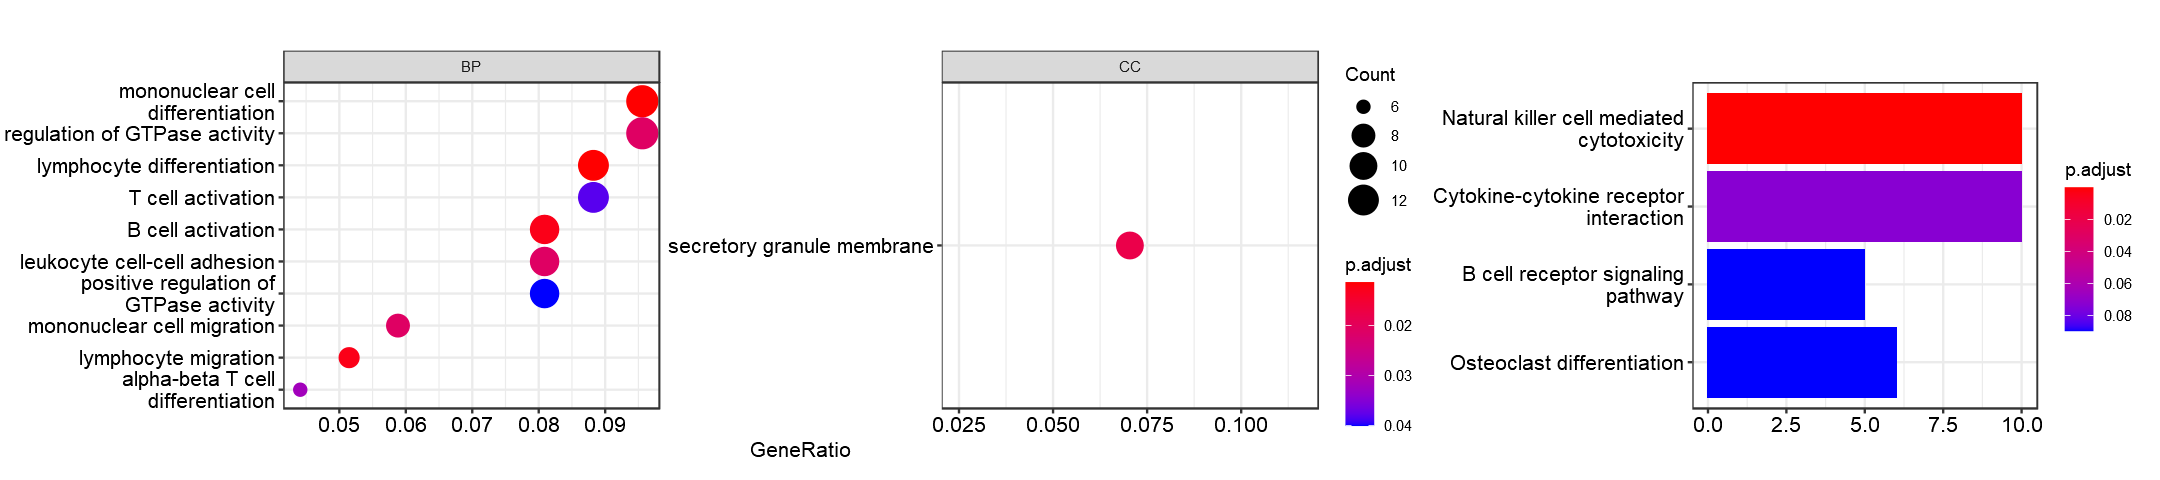

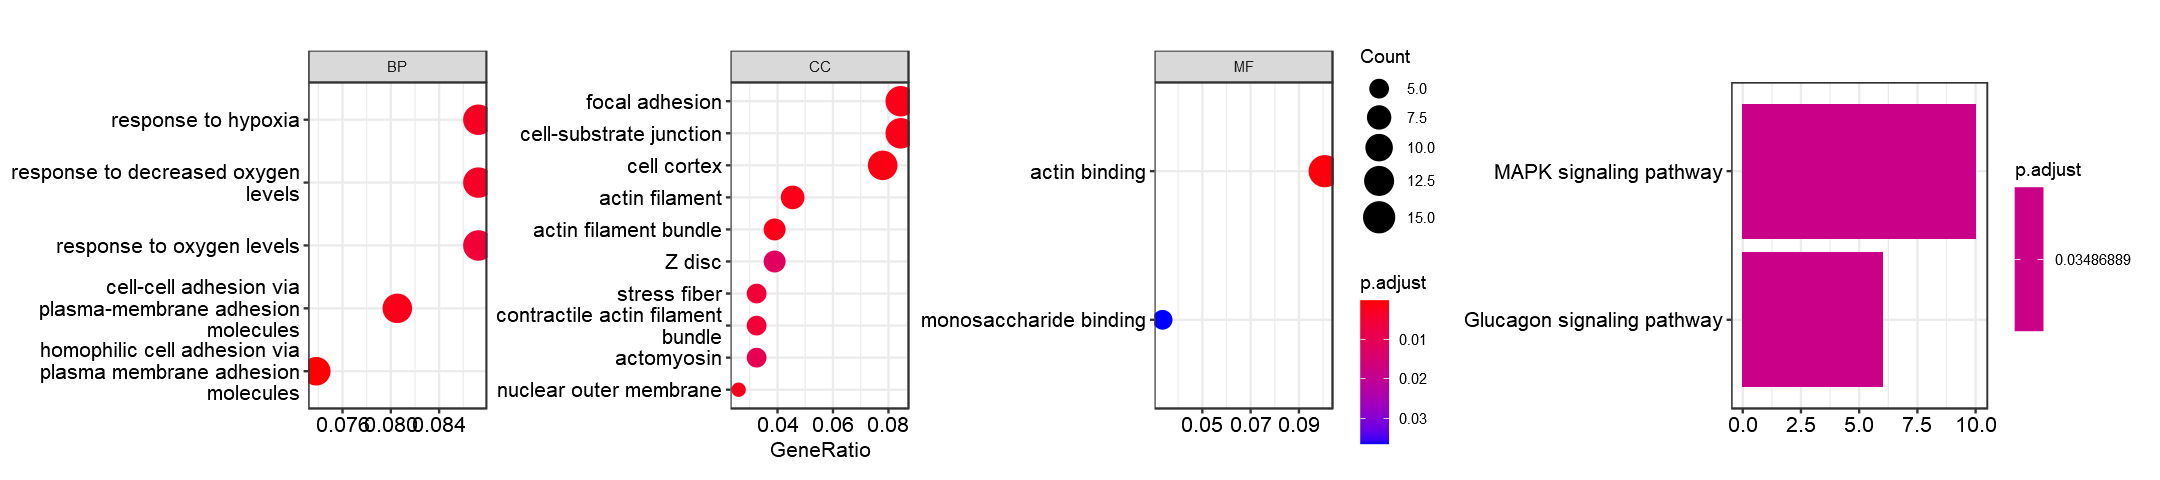

In [90]:
library(patchwork)
options(repr.plot.width = 18, repr.plot.height =4)
g_pos<-g_pos_go+g_pos_kegg+plot_layout(nrow=1,widths=c(3,1))
g_neg<-g_neg_go+g_neg_kegg+plot_layout(nrow=1,widths=c(4,1))
g_pos
g_neg

In [96]:
pdf("Fig5.pos_go_kegg.pdf",13,4)
g_pos
dev.off()

pdf("Fig5.neg_go_kegg.pdf",16,4)
g_neg
dev.off()

png 
  2

png 
  2

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL", :
"3.4% of input gene IDs are fail to map..."


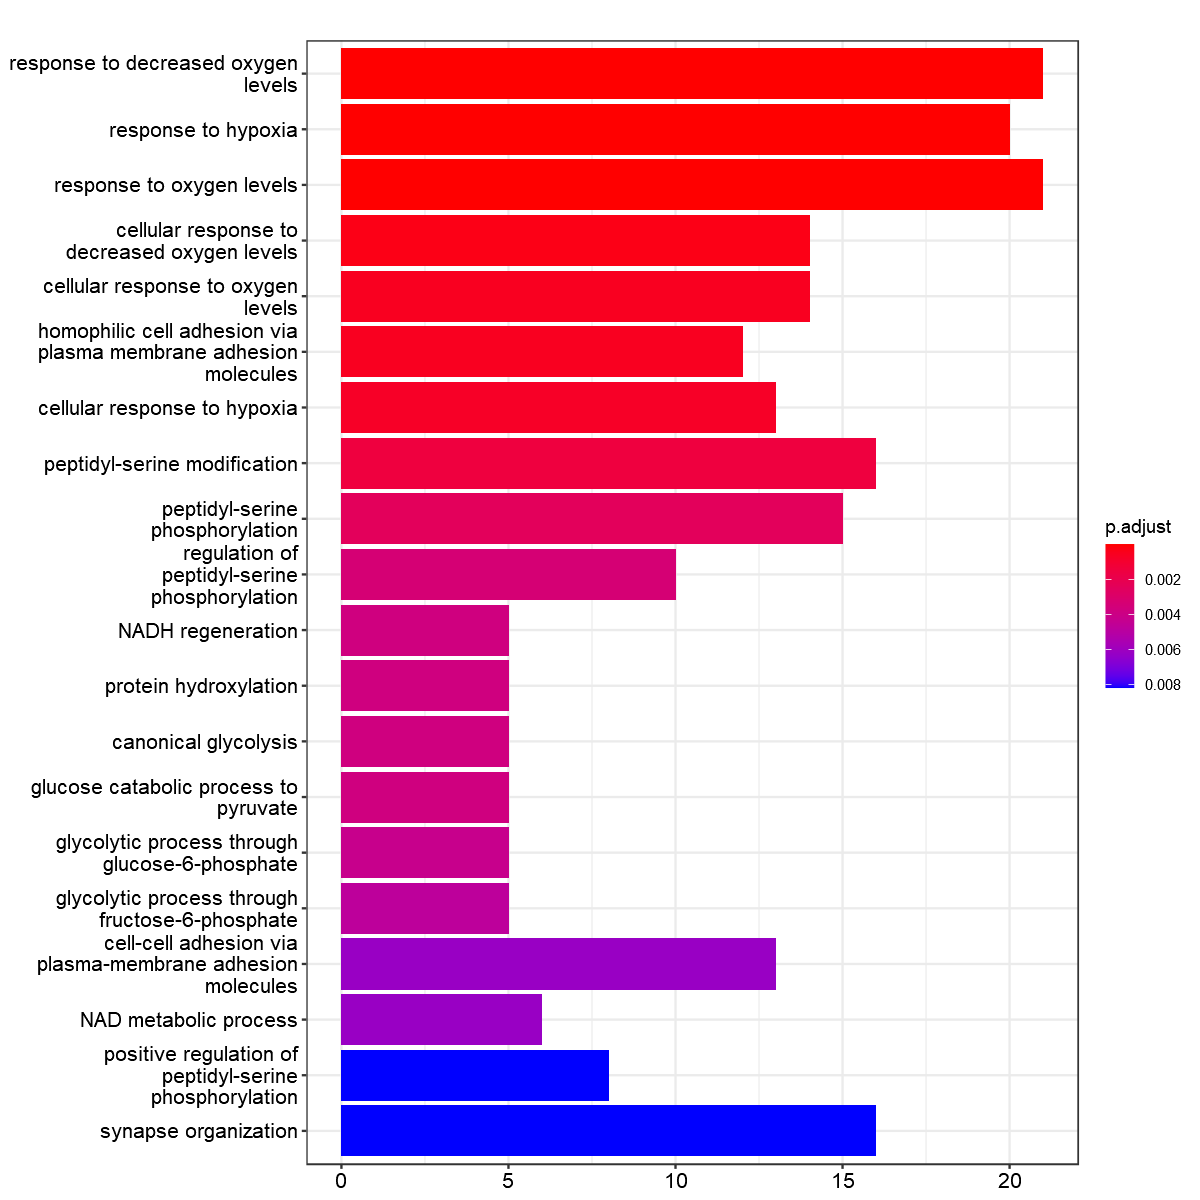

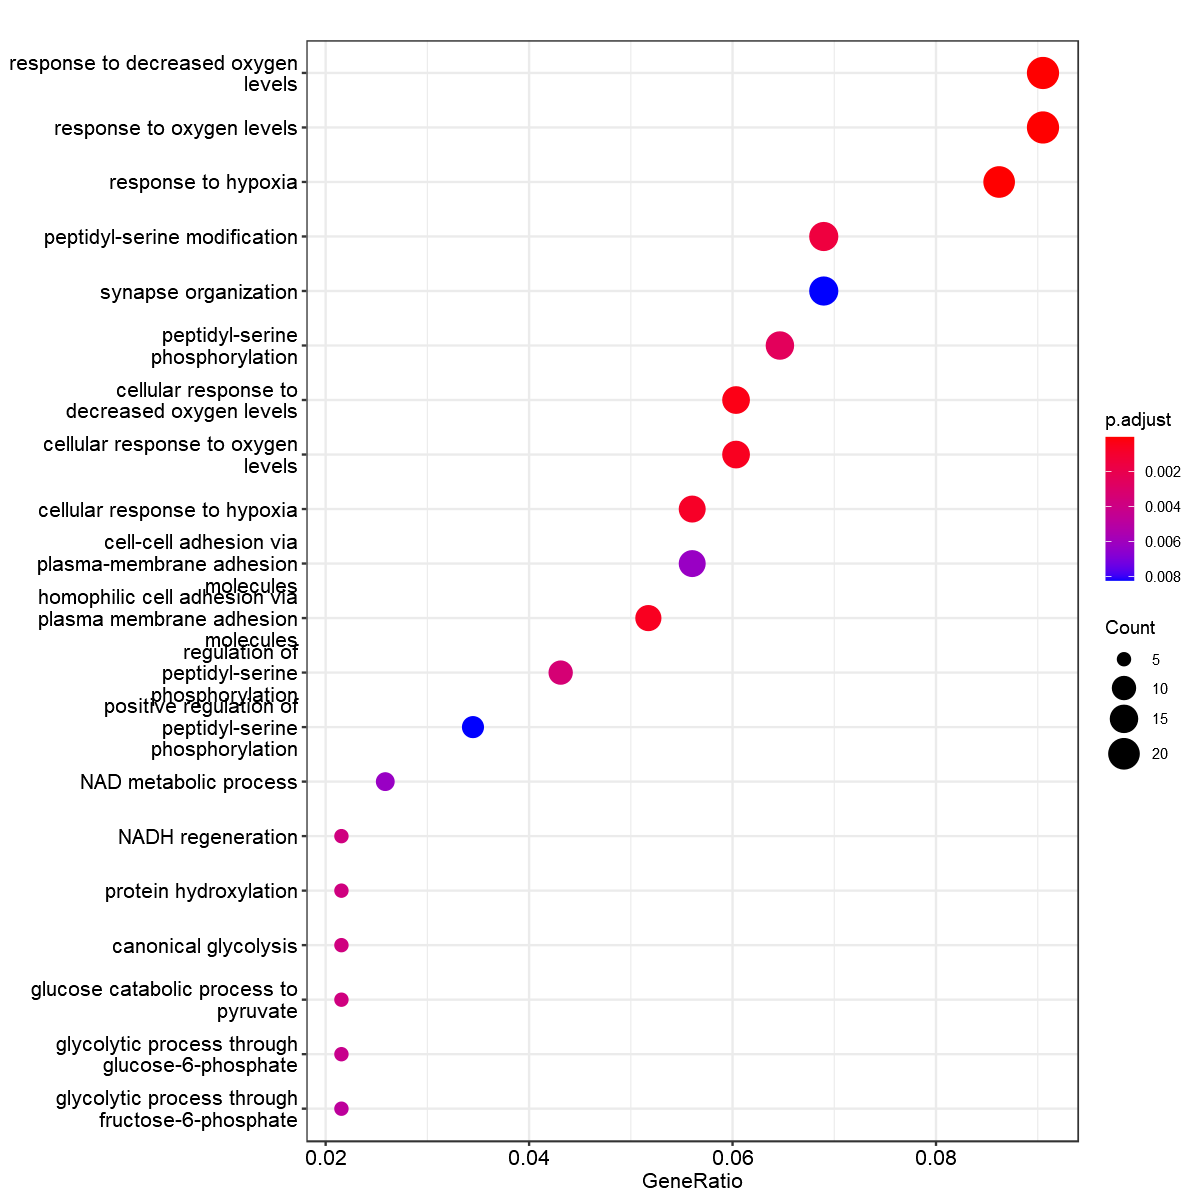

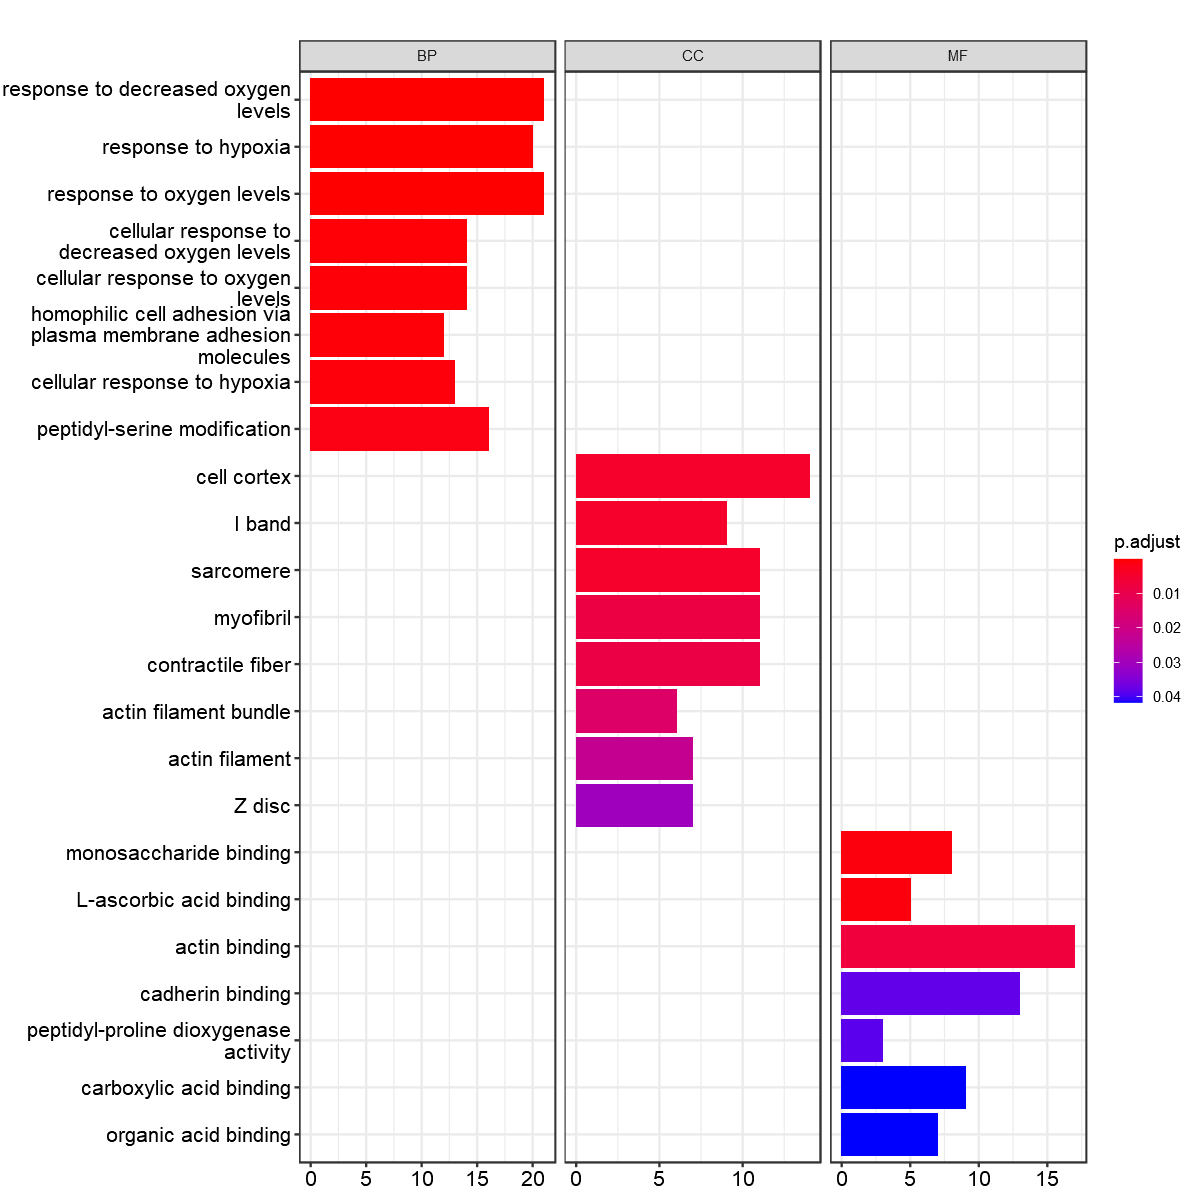

,GeneSymbol,Rho,p_value,type
,<chr>,<dbl>,<dbl>,<chr>
41120,ENO1,-0.1822207,4.789717e-05,T
41128,AKT1,-0.1834128,4.263512e-05,T
41154,EGLN3,-0.1857080,3.400606e-05,T
41173,GAPDH,-0.1897555,2.266989e-05,T
41185,CAMK2A,-0.1915449,1.889739e-05,T
41197,ALDOA,-0.1932106,1.592804e-05,T
41273,LDHA,-0.2100131,2.614744e-06,T
41281,PGK1,-0.2120669,2.074874e-06,T
41334,VEGFA,-0.2321207,1.920481e-07,T


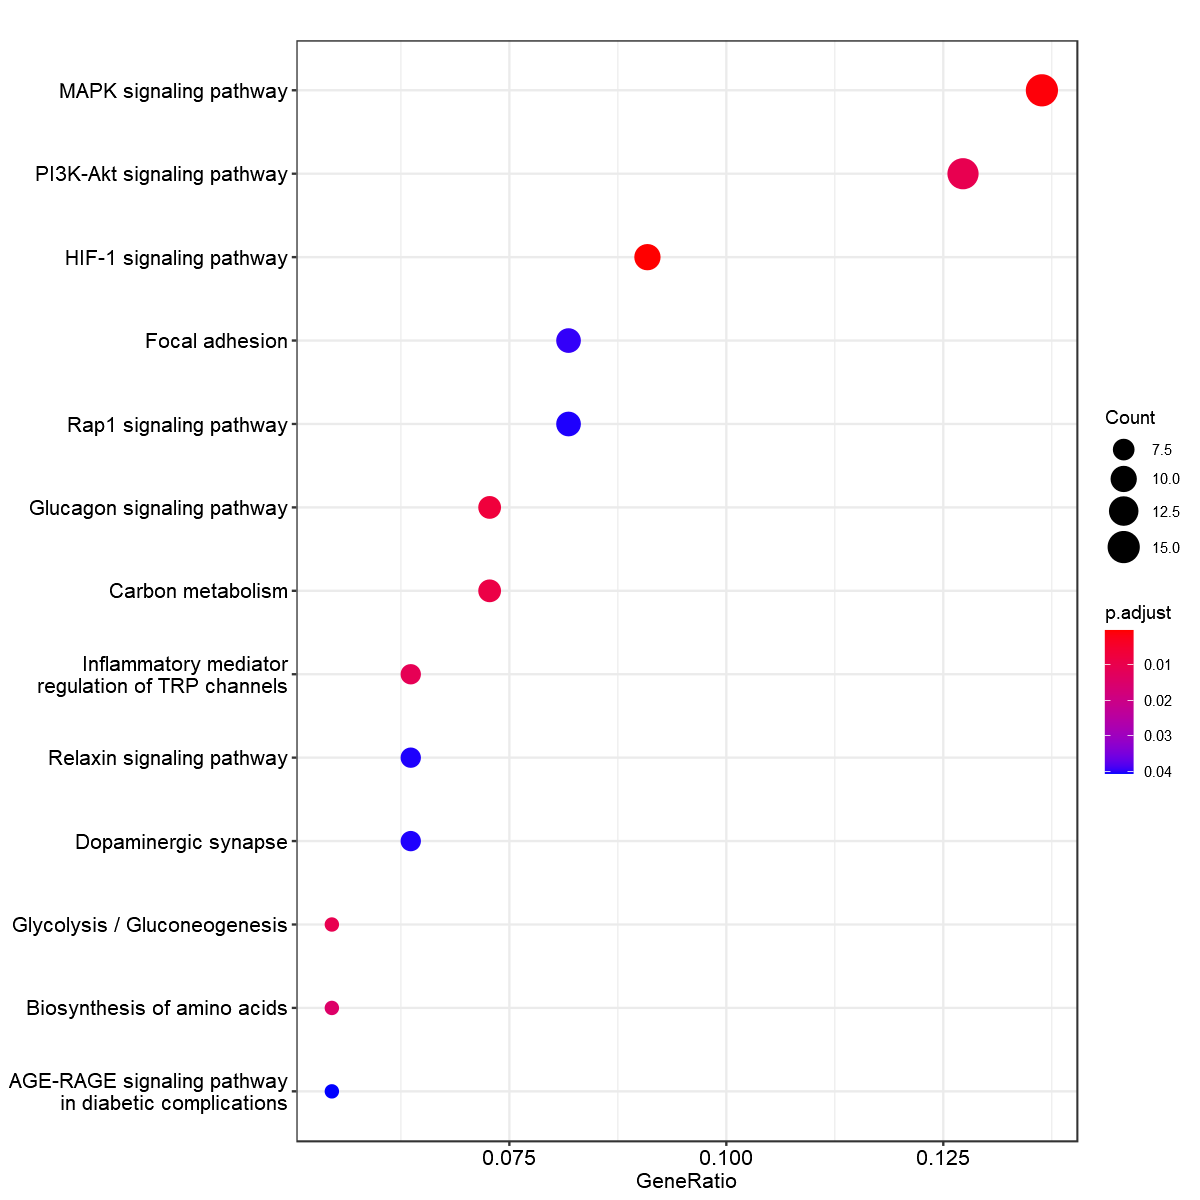

In [52]:
library(org.Hs.eg.db) #人类注释数据库
library(clusterProfiler)#进行GO富集和KEGG富集

x<-T_low$GeneSymbol
hg<-bitr(x,fromType="SYMBOL",toType=c("ENTREZID","ENSEMBL","SYMBOL"),OrgDb="org.Hs.eg.db")
hg<-hg[!duplicated(hg$ENTREZID),]

go <- enrichGO(hg$ENTREZID,OrgDb = org.Hs.eg.db, ont='ALL',pAdjustMethod = 'BH',pvalueCutoff = 0.05, qvalueCutoff = 0.2,keyType = 'ENTREZID')

#GO
barplot(go,showCategory=20,drop=T)#柱状图
dotplot(go,showCategory=20)#柱状图
barplot(go, split="ONTOLOGY")+ facet_grid(.~ONTOLOGY,scale="free")
#dotplot(go, split="ONTOLOGY")+ facet_grid(.~ONTOLOGY,scale="free")


#KEGG
R.utils::setOption("clusterProfiler.download.method",'auto')
#########
kegg <- enrichKEGG(hg$ENTREZID, organism = 'hsa', keyType = 'kegg', 
                   pvalueCutoff = 0.05, pAdjustMethod = 'BH',
                   minGSSize = 3, maxGSSize = 500, qvalueCutoff = 0.2, 
                   use_internal_data = FALSE)#进行KEGG富集
dotplot(kegg,showCategory=20)

kegg_ENTREZID<-strsplit(kegg$geneID[[1]],"/") %>% unlist()
kegg_SYMBOL<-hg$SYMBOL[hg$ENTREZID %in% kegg_ENTREZID]
T_low[T_low$GeneSymbol %in% kegg_SYMBOL,]

### 3.3.7 肿瘤特异性正相关基因和负相关基因的Log-rank和harzard ratiao分析

In [31]:
library(survival)
library(survminer)

options(repr.plot.width = 8, repr.plot.height = 8)

dim(T_high)
dim(T_low)
celltypes<-rbind(T_high,T_low)$GeneSymbol
T_survival_cibersort<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]

gene_cox_harzard_list<-tibble()

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

T_survival_cibersort$celltype_flag<-factor(T_survival_cibersort$celltype_flag,levels=c("low","high"))
    cox <- coxph(Surv(Survival_time,Survival_status) ~ celltype_flag,data=T_survival_cibersort)
    coxSummary = summary(cox)
    gene_cox_harzard_list=rbind(gene_cox_harzard_list,
                            cbind(id=celltype,
                            HR=coxSummary$conf.int[,"exp(coef)"],
                            HR.95L=coxSummary$conf.int[,"lower .95"],
                            HR.95H=coxSummary$conf.int[,"upper .95"],
                            pvalue=coxSummary$coefficients[,"Pr(>|z|)"]))
}

gene_cox_harzard_list$HR<-as.numeric(gene_cox_harzard_list$HR)
gene_cox_harzard_list$pvalue<-as.numeric(gene_cox_harzard_list$pvalue)
gene_cox_harzard_list$p.adj<-p.adjust(gene_cox_harzard_list$pvalue,method = "BH")
gene_cox_harzard_list[1:5,]

载入需要的程辑包：ggpubr


载入程辑包：'ggpubr'


The following object is masked from 'package:VennDiagram':

    rotate


The following object is masked from 'package:cowplot':

    get_legend



载入程辑包：'survminer'


The following object is masked from 'package:survival':

    myeloma




[1] 168   5

[1] 173   5

,id,HR,HR.95L,HR.95H,pvalue,p.adj
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,AMPD1,0.5624216,0.42186467662913,0.749809349392431,8.765537e-05,0.001758264
2,DCC,0.6410517,0.481686726610788,0.85314234063642,2.295117e-03,0.013094668
3,TNFRSF17,0.9596439,0.723543659813987,1.27278615788409,7.749593e-01,0.818145872
4,KCNN3,0.5975534,0.448847863033622,0.795525705630279,4.207211e-04,0.005193536
5,IL5RA,0.7077302,0.532532810847663,0.940565546509832,1.720905e-02,0.046045707


In [ ]:
write.csv(gene_cox_harzard_list,"IGHG1_cor_gene_cox_harzard_list")

进一步增加细节，比如标出那些倍数变化显著的基因。
先选取出这些基因：运用两次ifelse函数来筛选出显著正调控和显著负调控的基因，以及没有显著变化的基因(no)
给火山图加上感兴趣基因文本标注：这里运用一个包更方便：ggrepel
继续丰富细节：增加辅助线等等

In [32]:
data<-gene_cox_harzard_list
data$changed <- factor(ifelse((data$p.adj<0.05 & (data$HR-1)>0.5)|(data$p.adj<0.05 & (data$HR-1<(-1/3))),
                              ifelse(data$HR > 1,'Increase','Decrease'),'no'),levels=c("Decrease","no","Increase"))

#select genes
Top20_genes<-c(T_high$GeneSymbol[1:20],T_low$GeneSymbol[1:20])
selectedgene<-data$id[!is.na(ifelse( (data$p.adj<0.05 & (data$HR-1)>0.5)|(data$p.adj<0.05 & (data$HR-1<(-1/3))),data$id,NA))]

data$selectedgene<-ifelse(data$id %in% selectedgene,ifelse(data$id %in% Top20_genes,paste("(",data$id,")",sep=""),data$id),NA)

head(data)

,id,HR,HR.95L,HR.95H,pvalue,p.adj,changed,selectedgene
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>
1,AMPD1,0.5624216,0.42186467662913,0.749809349392431,8.765537e-05,0.001758264,Decrease,(AMPD1)
2,DCC,0.6410517,0.481686726610788,0.85314234063642,2.295117e-03,0.013094668,Decrease,(DCC)
3,TNFRSF17,0.9596439,0.723543659813987,1.27278615788409,7.749593e-01,0.818145872,no,NA
4,KCNN3,0.5975534,0.448847863033622,0.795525705630279,4.207211e-04,0.005193536,Decrease,(KCNN3)
5,IL5RA,0.7077302,0.532532810847663,0.940565546509832,1.720905e-02,0.046045707,no,NA
6,AC012236.1,0.7271148,0.546967991561469,0.966593827183256,2.824429e-02,0.064208678,no,NA


In [33]:
write.csv(data,"Fig4C.csv",quote=FALSE,row.names=FALSE)

# Fig4C

Warning message:
"Removed 263 rows containing missing values (geom_text_repel)."


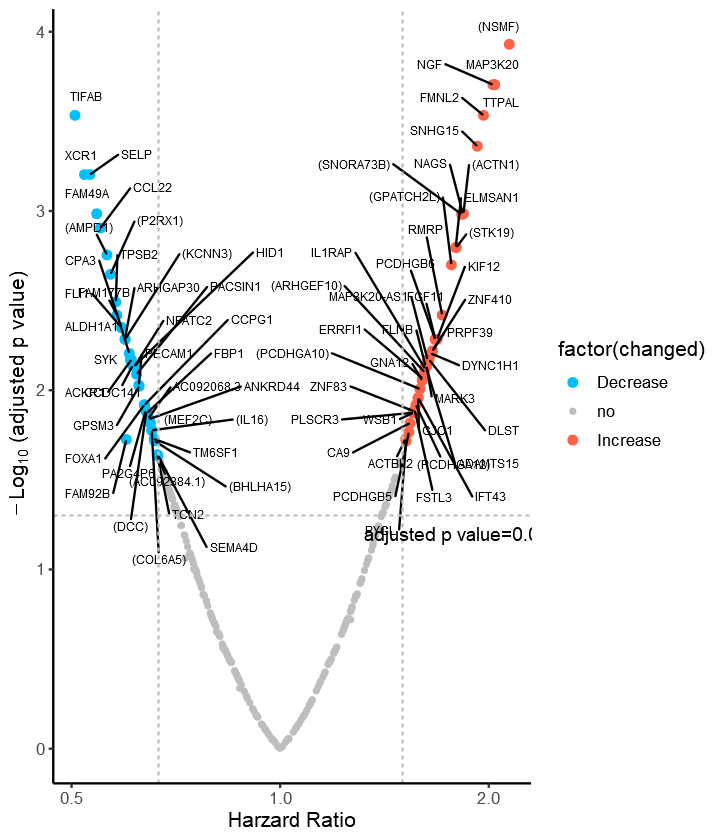

In [48]:
options(repr.plot.width = 6, repr.plot.height = 7)

  p_voc<-ggplot(data,aes(HR,-log10(p.adj),
                color=factor(changed),
                size=factor(changed)))+  
  geom_point()+
  labs(x=expression("Harzard Ratio"),
       y=expression(-Log[10]*" (adjusted p value)"))+
  scale_color_manual(values = c('deepskyblue','grey','tomato'))+
  scale_size_manual(values = c(2,1,2))+ 
  #ggrepel包内的函数给选择的基因加上文本标签:
     geom_text_repel(aes(label=selectedgene), color="black",size=2.5,
                  box.padding=unit(0.5, "lines"), 
                  point.padding=NA, 
                  segment.colour = "black",
                  max.overlaps=50) +
  geom_hline(yintercept = -log10(0.05),linetype=2,cex=.5,col="grey")+  #添加辅助线
  geom_vline(xintercept = c(1-1/3,1.5),linetype=2,cex=.5,col="grey")+
  annotate("text",x=1.8,y=1.2,label="adjusted p value=0.05",size=4)+ #添加一个注明
  theme_classic()+
  theme(text=element_text(colour = "black",size=12))+
  scale_x_log10()

p_voc

In [49]:
pdf("Fig5.harzard_volcano.pdf",5,6)
p_voc
dev.off()

Warning message:
"Removed 263 rows containing missing values (geom_text_repel)."


png 
  2

In [ ]:
colnames(T_survival_cibersort)

In [171]:
#T
T_survival_cibersort<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]

gene_cox_harzard_list<-tibble()

for (celltype in celltypes){
#gene="IGHG_redundant"

patients<-unique(T_survival_cibersort$Patient_ID)
data_m<-tibble()
    for(p in patients){
        p_data<-T_survival_cibersort[T_survival_cibersort$Patient_ID==p,colnames(T_survival_cibersort) %in% c("Survival_time","Survival_status",celltype)]
        p_data_m<-p_data[1,]
        p_data_m[,3] = median(p_data[,celltype])
        data_m<-rbind(data_m,p_data_m)
    }

data_m$celltype_flag[data_m[,celltype]>median(data_m[,celltype])]<-"high"
data_m$celltype_flag[data_m[,celltype]<=median(data_m[,celltype])]<-"low"

data_m$celltype_flag<-factor(data_m$celltype_flag,levels=c("low","high"))
    cox <- coxph(Surv(Survival_time,Survival_status) ~ celltype_flag,data=data_m)
    coxSummary = summary(cox)
    gene_cox_harzard_list=rbind(gene_cox_harzard_list,
                            cbind(id=celltype,
                            HR=coxSummary$conf.int[,"exp(coef)"],
                            HR.95L=coxSummary$conf.int[,"lower .95"],
                            HR.95H=coxSummary$conf.int[,"upper .95"],
                            pvalue=coxSummary$coefficients[,"Pr(>|z|)"]))
}

gene_cox_harzard_list$HR<-as.numeric(gene_cox_harzard_list$HR)
gene_cox_harzard_list$pvalue<-as.numeric(gene_cox_harzard_list$pvalue)
gene_cox_harzard_list$p.adj<-p.adjust(gene_cox_harzard_list$pvalue,method = "BH")
gene_cox_harzard_list[1:5,]

harzard_T<-gene_cox_harzard_list
harzard_T$type="T"

write.csv(harzard_T,"harzard_T_using_median_expression_Tumor_sample.csv",quote=FALSE,row.names=FALSE)

,id,HR,HR.95L,HR.95H,pvalue,p.adj
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,AMPD1,0.5128454,0.275128787486328,0.955953803852261,0.0355762,0.4652834
2,DCC,0.5646890,0.304444048736365,1.04739676869937,0.0698241,0.4929987
3,TNFRSF17,1.0911513,0.595115982212219,2.00063723631566,0.7779223,0.9198878
4,KCNN3,0.6869337,0.373536557831419,1.26327092863049,0.2270089,0.6006820
5,IL5RA,0.6689091,0.362812641608412,1.23325183260198,0.1976512,0.5912198


In [ ]:
#N
T_survival_cibersort<-survival_IGH_deversity_gene_expr_deconv[grep("N",survival_IGH_deversity_gene_expr_deconv$type),]

gene_cox_harzard_list<-tibble()

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

T_survival_cibersort$celltype_flag<-factor(T_survival_cibersort$celltype_flag,levels=c("low","high"))
    cox <- coxph(Surv(Survival_time,Survival_status) ~ celltype_flag,data=T_survival_cibersort)
    coxSummary = summary(cox)
    gene_cox_harzard_list=rbind(gene_cox_harzard_list,
                            cbind(id=celltype,
                            HR=coxSummary$conf.int[,"exp(coef)"],
                            HR.95L=coxSummary$conf.int[,"lower .95"],
                            HR.95H=coxSummary$conf.int[,"upper .95"],
                            pvalue=coxSummary$coefficients[,"Pr(>|z|)"]))
}

gene_cox_harzard_list$HR<-as.numeric(gene_cox_harzard_list$HR)
gene_cox_harzard_list$pvalue<-as.numeric(gene_cox_harzard_list$pvalue)
gene_cox_harzard_list$p.adj<-p.adjust(gene_cox_harzard_list$pvalue,method = "BH")
gene_cox_harzard_list[1:5,]

harzard_N<-gene_cox_harzard_list
harzard_N$type="N"


In [ ]:

write.csv(harzard_N,"harzard_N.csv",quote=FALSE,row.names=FALSE)

### 读取T、L高相关性基因的Cox hazard list，作图

In [34]:
harzard_T<-fread("Fig4D.harzard_T_using_median_expression_Tumor_sample.csv")
harzard_N<-fread("Fig4D.harzard_N.csv")

harzard_TN<-rbind(harzard_T,harzard_N)


In [36]:
write.csv(harzard_TN,"Fig4D.csv",quote=FALSE,row.names=FALSE)

# Fig4D

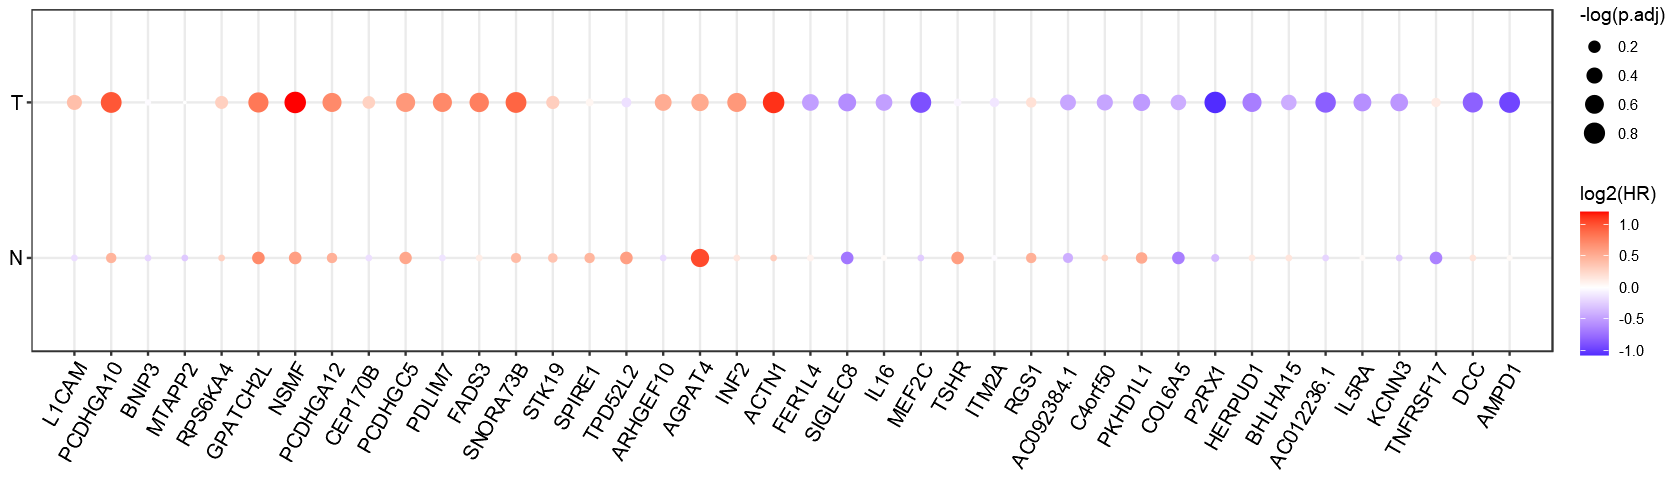

In [57]:

library(ggplot2)
options(repr.plot.width = 14, repr.plot.height = 4)

Top20_genes<-c(T_high$GeneSymbol[1:20],T_low$GeneSymbol[1:20])
data<-harzard_TN[harzard_TN$id %in% Top20_genes,]
data$type<-factor(data$type,levels=c("N","T"))
data$id<-factor(data$id,levels=rev(Top20_genes))


p_dot_hazard<-ggplot(data,aes(y=type,x=id,color=log2(HR))) +
  geom_point(aes(size=-log(p.adj))) +
  scale_size(rang = c(0,5)) +
  scale_x_discrete(position = "bottom" ,expand=c(0.03,0))+
  labs(x=NULL,y=NULL)+
  theme_bw()+
  theme(axis.text.x=element_text(angle=60,hjust = 1,vjust=1),
        axis.text =element_text(size = 12, color = "black"),
        )+ 
      scale_color_gradient2(low = "blue", high = "red",mid = "white",midpoint=0)

p_dot_hazard

In [59]:
pdf("Fig5.p_dot_hazard.pdf",8,2.5)
p_dot_hazard
dev.off()

png 
  2

# 四、各基因、细胞类型、diversity feature生存曲线

In [40]:
survival_IGH_deversity_gene_expr_deconv<-read.csv("survival_IGH_deversity_gene_expr_deconv.csv",header=TRUE)

In [68]:
colnames(survival_IGH_deversity_gene_expr_deconv)[grep("Mcp",colnames(survival_IGH_deversity_gene_expr_deconv))]
colnames(survival_IGH_deversity_gene_expr_deconv)[grep("Ciber",colnames(survival_IGH_deversity_gene_expr_deconv))]

[1] "Mcp_counter.T cell"                      
 [2] "Mcp_counter.T cell CD8+"                 
 [3] "Mcp_counter.cytotoxicity score"          
 [4] "Mcp_counter.NK cell"                     
 [5] "Mcp_counter.B cell"                      
 [6] "Mcp_counter.Monocyte"                    
 [7] "Mcp_counter.Macrophage/Monocyte"         
 [8] "Mcp_counter.Myeloid dendritic cell"      
 [9] "Mcp_counter.Neutrophil"                  
[10] "Mcp_counter.Endothelial cell"            
[11] "Mcp_counter.Cancer associated fibroblast"

[1] "Cibersort.B cells naive"               
 [2] "Cibersort.B cells memory"              
 [3] "Cibersort.Plasma cells"                
 [4] "Cibersort.T cells CD8"                 
 [5] "Cibersort.T cells CD4 naive"           
 [6] "Cibersort.T cells CD4 memory resting"  
 [7] "Cibersort.T cells CD4 memory activated"
 [8] "Cibersort.T cells follicular helper"   
 [9] "Cibersort.T cells regulatory (Tregs)"  
[10] "Cibersort.T cells gamma delta"         
[11] "Cibersort.NK cells resting"            
[12] "Cibersort.NK cells activated"          
[13] "Cibersort.Monocytes"                   
[14] "Cibersort.Macrophages M0"              
[15] "Cibersort.Macrophages M1"              
[16] "Cibersort.Macrophages M2"              
[17] "Cibersort.Dendritic cells resting"     
[18] "Cibersort.Dendritic cells activated"   
[19] "Cibersort.Mast cells resting"          
[20] "Cibersort.Mast cells activated"        
[21] "Cibersort.Eosinophils"                 
[22] "Cibersort.Neutrophils"                 
[23] "Cibersort.P-value"                     
[24] "Cibersort.Correlation"                 
[25] "Cibersort.RMSE"

#### log_rang_p matrix

In [48]:
# HH HL
log_rank_p_mat<-tibble()
for(x in c("High/High","High/Low","Low/High","Low/Low")){
    for (y in c("High/High","High/Low","Low/High","Low/Low")){
        if(x==y){next}
        selected<-T_survival_cibersort$celltype_flag==x | T_survival_cibersort$celltype_flag==y
        data_selected<-T_survival_cibersort[selected,]
        fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=data_selected)
        p=round(surv_pvalue(fit)$pval,5)
        
        row=c(x,y,p)
        log_rank_p_mat<-rbind(log_rank_p_mat,row)
    }
}

colnames(log_rank_p_mat)<-c("V1","V2","pval")
log_rank_p_mat

Warning message in max(event[who2]):
"max里所有的参数都不存在；回覆-Inf"


ERROR: Error in survfit.formula(Surv(Survival_time, Survival_status) ~ celltype_flag, : data set has no non-missing observations


In [49]:
#expr
data_multi<-fread("D:/Postdoc/Projects/ESCC_TCR/Deconvolution/MR_expr_cibersort_input.new.txt")%>% as.data.frame()
data_multi_expr<-column_to_rownames(data_multi,var="GENE")

data_multi_mat<-t(data_multi_expr)
colnames(data_multi_mat)<-data_multi[,1]
MR_expr<-as.data.frame(data_multi_mat)
#MR_expr<-rownames_to_column(MR_expr,var="ID")

dim(MR_expr)
MR_expr[1:5,1:5]

[1]   654 60583

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ESCC001N,38.47,0.18,38.96,3.80,3.79
ESCC001T1,7.41,0.00,73.86,2.85,8.43
ESCC001T2,6.30,0.00,91.77,2.21,7.76
ESCC001T3,9.95,0.00,110.20,2.27,7.66
ESCC001T4,5.61,0.00,117.69,2.19,8.86


## 4.3 IGHG1高低排列的热图

In [50]:
head(high_cor_genes_T)

,GeneSymbol,Rho,p_value,type,p_adj
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
41418,FKBP8,-0.3921612,1.550678e-19,T,6.342275e-15
41417,ACTN1,-0.3548188,4.826167e-16,T,1.967194e-11
41416,INF2,-0.3293686,6.510897e-14,T,2.645768e-09
41415,AGPAT4,-0.3203872,3.307049e-13,T,1.342166e-08
41414,ARHGEF10,-0.3064730,3.691697e-12,T,1.494399e-07
41413,PFKP,-0.3052052,4.570696e-12,T,1.849852e-07


In [52]:
#使用的基因 pos 97，neg ？
high_cor_genes<-read.csv("high_cor_genes_IGHG1_richness_TNL.csv",header=TRUE)

#positive cor genes
high_cor_genes_T<-high_cor_genes[high_cor_genes$type=="T",]
high_cor_genes_N<-high_cor_genes[high_cor_genes$type=="N",]

T_pos<-high_cor_genes_T[1:500,]$GeneSymbol
N_pos<-high_cor_genes_N[1:1000,]$GeneSymbol
T_pos<-T_pos[-grep("^IG",T_pos)]
T_pos<-T_pos[-grep("^TRB",T_pos)]
T_pos<-T_pos[-grep("^TRA",T_pos)]
T_specific_genes_pos<-T_pos[!T_pos %in% N_pos]
length(T_specific_genes_pos)

#negative cor genes
high_cor_genes_T<-high_cor_genes_T[order(high_cor_genes_T$Rho,decreasing = FALSE),]
high_cor_genes_N<-high_cor_genes_N[order(high_cor_genes_N$Rho,decreasing = FALSE),]

T_neg<-high_cor_genes_T[1:250,]$GeneSymbol
N_neg<-high_cor_genes_N[1:500,]$GeneSymbol

T_specific_genes_neg<-T_neg[!T_neg %in% N_neg]
length(T_specific_genes_neg)

selected_genes<-c(T_specific_genes_pos,T_specific_genes_neg)

high_cor_genes_T$p_adj<-p.adjust(high_cor_genes_T$p_value)
high_cor_genes_T<-high_cor_genes_T[high_cor_genes_T$p_adj<0.05,]
high_cor_genes_T$GeneSymbol[high_cor_genes_T$GeneSymbol %in% selected_genes] %>% length()

selected_genes<-high_cor_genes_T$GeneSymbol[high_cor_genes_T$GeneSymbol %in% selected_genes]

[1] 94

[1] 217

[1] 197

#### 4.3.1 整理heatmap数据

In [99]:
selected_Top20_genes<-c(T_specific_genes_pos[1:20],T_specific_genes_neg[1:20])

survival_data<-T_data
#使用的多样性指数
diversity_features<-c('s_richness','s_shannon',
    'sequence.richness.IGHM',
    'sequence.richness.IGHD',
    'sequence.richness.IGHA1','sequence.richness.IGHA2',
    'sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4',
    'sequence.richness.IGHE'
    )

#使用的细胞类型
cb_celltype<-colnames(T_data)[grep("Ciber",colnames(T_data))]
mcp_celltype<-colnames(T_data)[grep("Mcp",colnames(T_data))]

celltypes<-c(cb_celltype,mcp_celltype)
celltypes<-celltypes[-grep("Cibersort.P-value",celltypes)]
celltypes<-celltypes[-grep("Cibersort.Correlation",celltypes)]
celltypes<-celltypes[-grep("Cibersort.RMSE",celltypes)]

dim(survival_data)

survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"ⅡII"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"ⅢIII"#,"\u2162" # Ⅲ
survival_data$TNM_flag[survival_data$TNM %in% c("IVa")]<-"ⅣIV"#"\u2163" # Ⅳ

survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

survival_data$Age_flag[survival_data$Age>=60]<-"older(>=60)"
survival_data$Age_flag[survival_data$Age<60]<-"younger"

survival_data$Location[survival_data$Location=="Upper&Lower"]="Upper"

selected_cols<-colnames(survival_data) %in% c("ID","Survival_time","Survival_status","Age_flag","Gender","Location","Smoking","Drinking","TNM_flag",diversity_features,celltypes,selected_Top20_genes)

heatmap_data<-survival_data[,selected_cols]

[1]   492 60728

#### 4.3.2 获取heatmap data，annotation data

In [100]:
colnames(survival_data)[data_cols]

[1] "ID"                                      
 [2] "s_richness"                              
 [3] "s_shannon"                               
 [4] "sequence.richness.IGHM"                  
 [5] "sequence.richness.IGHD"                  
 [6] "sequence.richness.IGHA1"                 
 [7] "sequence.richness.IGHA2"                 
 [8] "sequence.richness.IGHG1"                 
 [9] "sequence.richness.IGHG2"                 
[10] "sequence.richness.IGHG3"                 
[11] "sequence.richness.IGHG4"                 
[12] "sequence.richness.IGHE"                  
[13] "Cibersort.B cells naive"                 
[14] "Cibersort.B cells memory"                
[15] "Cibersort.Plasma cells"                  
[16] "Cibersort.T cells CD8"                   
[17] "Cibersort.T cells CD4 naive"             
[18] "Cibersort.T cells CD4 memory resting"    
[19] "Cibersort.T cells CD4 memory activated"  
[20] "Cibersort.T cells follicular helper"     
[21] "Cibersort.T cells regulatory (Tregs)"    
[22] "Cibersort.T cells gamma delta"           
[23] "Cibersort.NK cells resting"              
[24] "Cibersort.NK cells activated"            
[25] "Cibersort.Monocytes"                     
[26] "Cibersort.Macrophages M0"                
[27] "Cibersort.Macrophages M1"                
[28] "Cibersort.Macrophages M2"                
[29] "Cibersort.Dendritic cells resting"       
[30] "Cibersort.Dendritic cells activated"     
[31] "Cibersort.Mast cells resting"            
[32] "Cibersort.Mast cells activated"          
[33] "Cibersort.Eosinophils"                   
[34] "Cibersort.Neutrophils"                   
[35] "Mcp_counter.T cell"                      
[36] "Mcp_counter.T cell CD8+"                 
[37] "Mcp_counter.cytotoxicity score"          
[38] "Mcp_counter.NK cell"                     
[39] "Mcp_counter.B cell"                      
[40] "Mcp_counter.Monocyte"                    
[41] "Mcp_counter.Macrophage/Monocyte"         
[42] "Mcp_counter.Myeloid dendritic cell"      
[43] "Mcp_counter.Neutrophil"                  
[44] "Mcp_counter.Endothelial cell"            
[45] "Mcp_counter.Cancer associated fibroblast"
[46] "AMPD1"                                   
[47] "DCC"                                     
[48] "TNFRSF17"                                
[49] "KCNN3"                                   
[50] "IL5RA"                                   
[51] "TPTE2"                                   
[52] "AC012236.1"                              
[53] "BHLHA15"                                 
[54] "HERPUD1"                                 
[55] "P2RX1"                                   
[56] "COL6A5"                                  
[57] "PKHD1L1"                                 
[58] "C4orf50"                                 
[59] "AC092384.1"                              
[60] "RGS1"                                    
[61] "ITM2A"                                   
[62] "TSHR"                                    
[63] "MEF2C"                                   
[64] "IL16"                                    
[65] "SIGLEC8"                                 
[66] "ACTN1"                                   
[67] "INF2"                                    
[68] "AGPAT4"                                  
[69] "ARHGEF10"                                
[70] "TPD52L2"                                 
[71] "SPIRE1"                                  
[72] "STK19"                                   
[73] "SNORA73B"                                
[74] "FADS3"                                   
[75] "PDLIM7"                                  
[76] "PCDHGC5"                                 
[77] "CEP170B"                                 
[78] "PCDHGA12"                                
[79] "NSMF"                                    
[80] "GPATCH2L"                                
[81] "RPS6KA4"                                 
[82] "MTAPP2"                                  
[83] "BNIP3"                                   
[84] "PCDHGA10"  

In [103]:
# annotation_cols<-colnames(survival_data) %in% c("ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag")
# data_cols<-colnames(survival_data) %in% c("ID",diversity_features,celltypes,selected_genes)

annotation_cols<-match(c("ID","Age","Gender","Location","TNM_flag","Smoking","Drinking","sequence.richness.IGHG1"),colnames(survival_data))
data_cols<-match(c("ID",diversity_features,celltypes,selected_Top20_genes),colnames(survival_data))
#data_cols<-match(c("ID","sequence.richness.IGHG1","sequence.richness.IGHG3",selected_genes),colnames(survival_data))


heatmap_data<-survival_data[,data_cols]
annotation_data<-survival_data[,annotation_cols]

#### scale heatmap，根据feature进行排序
row.names(heatmap_data)<-heatmap_data$ID
heatmap_data<-heatmap_data[,-1]
heatmap_data_scaled<-scale(heatmap_data)

feature_to_be_order<-"sequence.richness.IGHG1"
order_by<-order(heatmap_data_scaled[,grep(feature_to_be_order,colnames(heatmap_data_scaled))],decreasing = FALSE)

heatmap_mat<-heatmap_data_scaled[order_by,]
annotation_data<-annotation_data[order_by,]


In [104]:

#### scale heatmap，根据feature进行排序
row.names(heatmap_data)<-heatmap_data$ID
heatmap_data<-heatmap_data#[,-1]
heatmap_data_scaled<-scale(heatmap_data)

feature_to_be_order<-"sequence.richness.IGHG1"
order_by<-order(heatmap_data_scaled[,grep(feature_to_be_order,colnames(heatmap_data_scaled))],decreasing = FALSE)

heatmap_mat<-heatmap_data_scaled[order_by,]
annotation_data<-annotation_data[order_by,]


#### 4.3.3 不同类型的data feature单独聚类，再rbind，获取聚类后的顺序

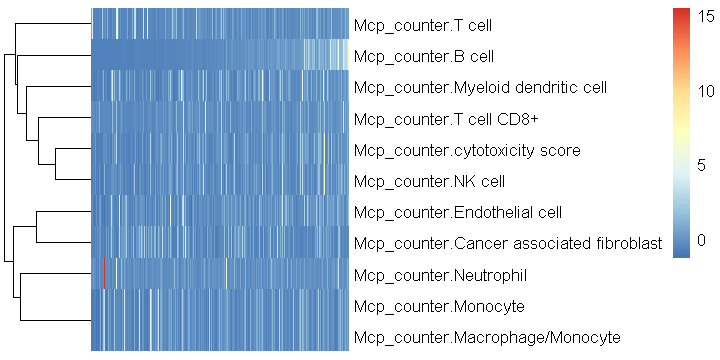

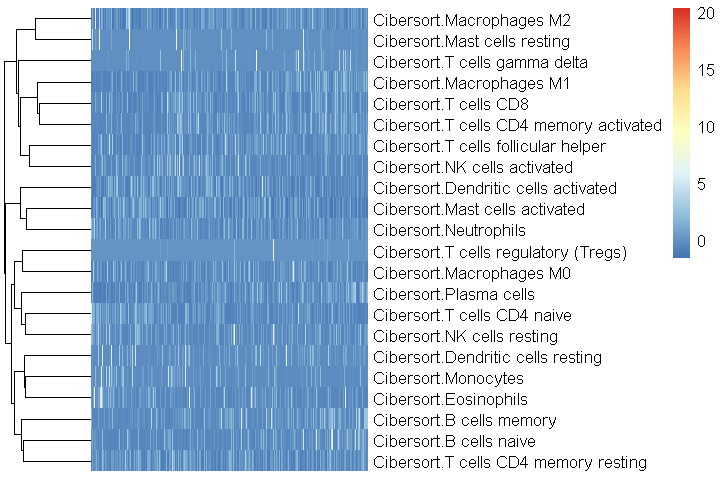

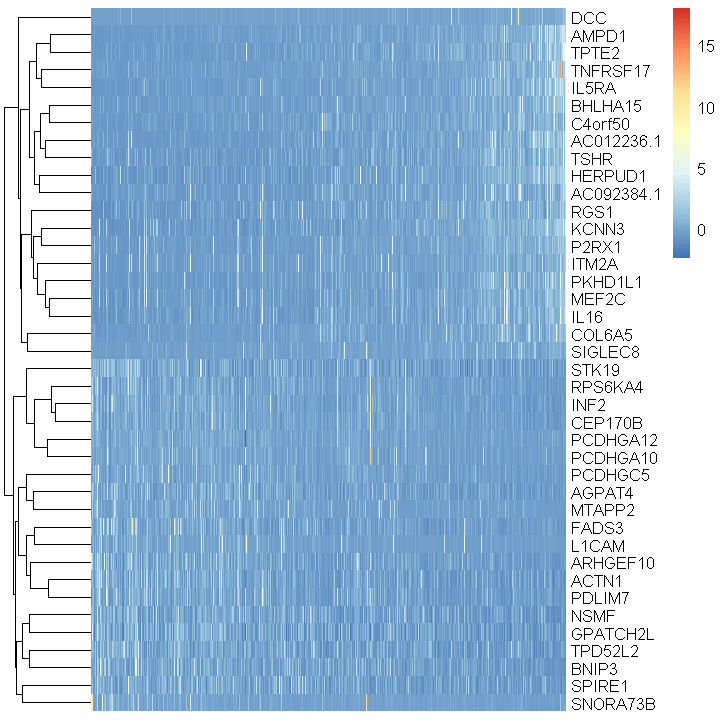

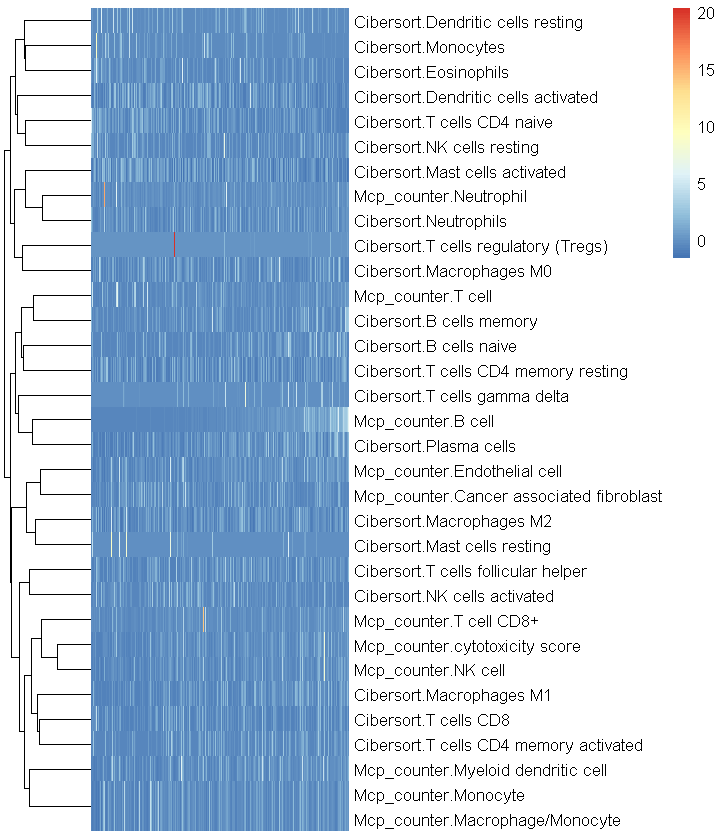

In [115]:
test<-t(heatmap_mat)
s_data<-test[grep("s_|sequence.richness.",row.names(test)),]

mcps<-test[grep("Mcp",row.names(test)),]

Cibs<-test[grep("Ciber",row.names(test)),]

celltypes<-rbind(mcps,Cibs)

Top20<-test[row.names(test) %in% selected_Top20_genes,]

options(repr.plot.width = 6, repr.plot.height = 3)
out1<-pheatmap(mcps,cluster_rows=TRUE,cluster_cols=FALSE)

options(repr.plot.width = 6, repr.plot.height =4)
out2<-pheatmap(Cibs,cluster_rows=TRUE,cluster_cols=FALSE)

options(repr.plot.width = 6, repr.plot.height = 6)
out3<-pheatmap(Top20,cluster_rows=TRUE,cluster_cols=FALSE)

options(repr.plot.width = 6, repr.plot.height = 7)
out4<-pheatmap(celltypes,cluster_rows=TRUE,cluster_cols=FALSE)

In [117]:
mcps<-mcps[out1$tree_row[["order"]],]
Cibs<-Cibs[out2$tree_row[["order"]],]
#Top20<-Top20[out3$tree_row[["order"]],]

dim(s_data)

test<-rbind(s_data,Top20,mcps,Cibs)

gaps_pos1<-rev(grep("sequence.richness.",row.names(test)))[1]
gaps_pos2<-rev(grep("L1CAM",row.names(test)))[1]
gaps_pos3<-rev(grep("Mcp",row.names(test)))[1]

test[test>1]=1
test[test<(-1)]=-1

[1]  11 492

In [128]:
gaps_pos3

[1] 62

In [129]:
gaps_pos1
gaps_pos2
gaps_pos3

[1] 11

[1] 51

[1] 62

In [118]:
#计算spearman Rho to IGHG1
cor_list<-tibble()
for (c in row.names(test)){
    x=test[match("sequence.richness.IGHG1",row.names(test)),]
    y=test[match(c,row.names(test)),]
    cor=cor.test(x,y,method="spearman")
    rows=tibble()
    rows<-c(c,cor$estimate,cor$p.value)
    cor_list<-rbind(cor_list,rows)
}

colnames(cor_list)<-c("celltype","Spearman's Rho","p.value")
cor_list$p.adj<-p.adjust(cor_list$p.value,method="BH")

#
annotation_rows<-cor_list

annotation_rows$celltype[annotation_rows$p.adj<0.05 & annotation_rows$p.adj>=0.001]<- paste(annotation_rows$celltype[annotation_rows$p.adj<0.05 & annotation_rows$p.adj>=0.001],"*", sep=" ")
annotation_rows$celltype[annotation_rows$p.adj<0.001]<- paste(annotation_rows$celltype[annotation_rows$p.adj<0.001],"**", sep=" ")

row.names(test)<-annotation_rows$celltype
row.names(annotation_rows)<-annotation_rows$celltype
annotation_rows<-annotation_rows[,2,drop=FALSE]
annotation_rows$`Spearman's Rho`<-as.numeric(annotation_rows$`Spearman's Rho`)

Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spe

Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, y, method = "spe

# Fig4B

In [123]:
library(pheatmap)
options(repr.plot.width = 10, repr.plot.height = 10)

annotation_cols<-annotation_data
annotation_cols$Smoking<-factor(annotation_cols$Smoking,levels=c("never","light","moderate","heavy"))
annotation_cols$Drinking<-factor(annotation_cols$Drinking,levels=c("never","light","moderate","heavy"))

row.names(annotation_cols)<-NULL

annotation_cols<-column_to_rownames(annotation_cols,var="ID")
ann_colors = list(
  TNM_flag=c(ⅡII="#95CACA",ⅢIII="#4F9D9D",ⅣIV="#336666"),
  sequence.richness.IGHG1 = c("#F2E6E6","#AE0000"),
  Smoking = c(never = "#F2E6E6", light = "#CF9E9E",moderate = "#984B4B",heavy="#613030"),
  Drinking = c(never = "#F2E6E6", light = "#CF9E9E",moderate = "#984B4B",heavy="#613030"),
  Gender=c(Female="#FF0080",Male="#0072E3"),
  Location=c(Lower="blue",Middle="#00CCCC",Upper="orange"),
  Age=c("#F3F3FA","#484891")
)


In [136]:
write.csv(test,"Fig4B.csv",row.names=FALSE,quote=FALSE)

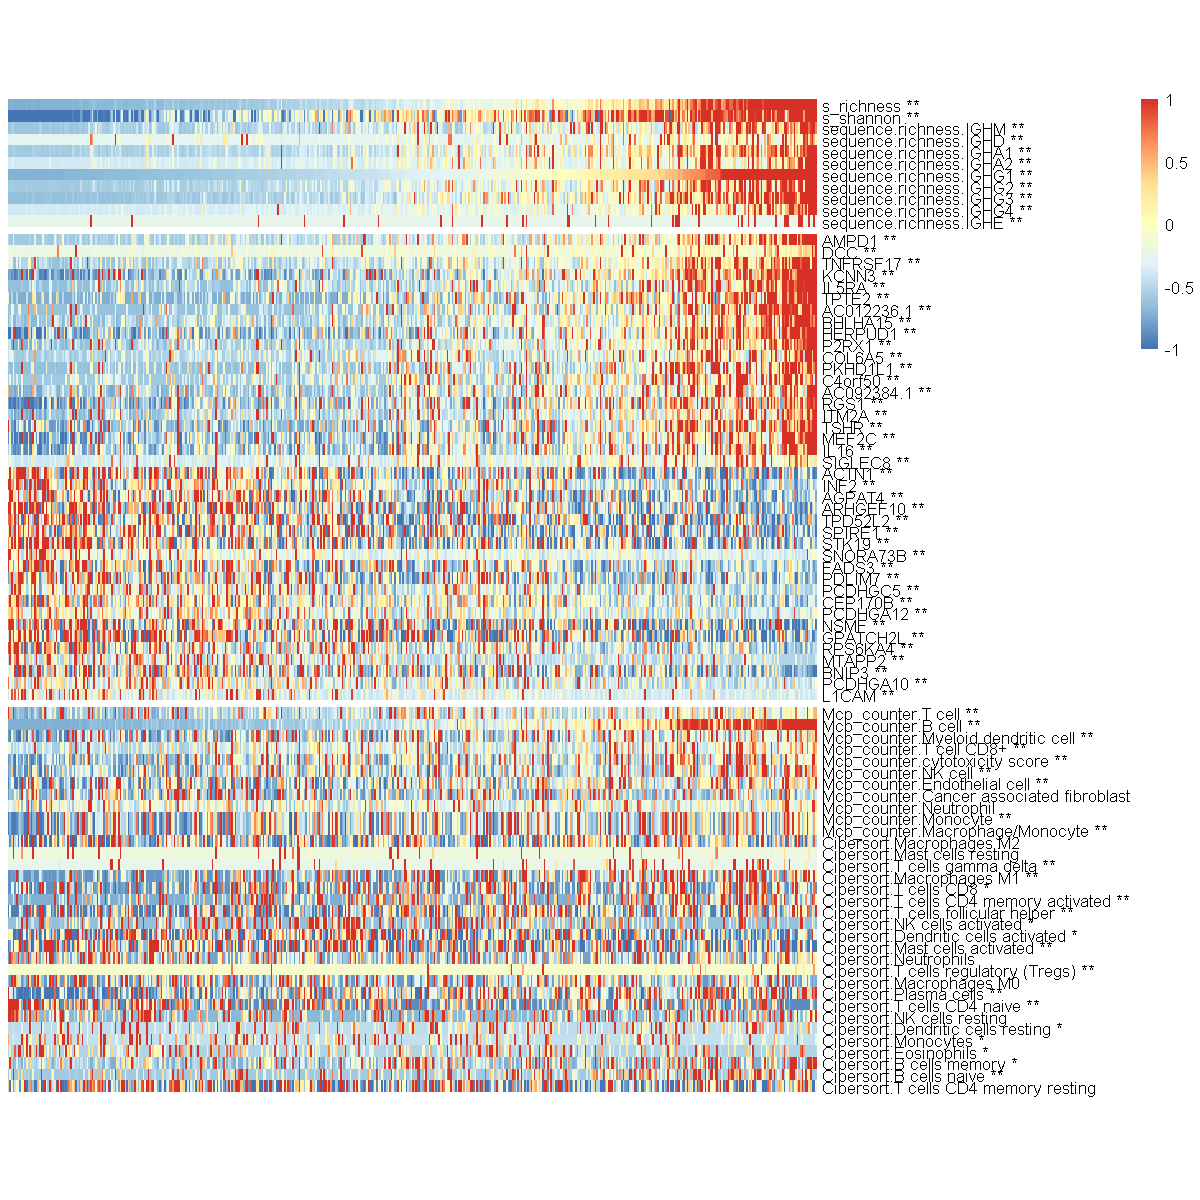

In [135]:
p_IGHG1<-pheatmap(test,cluster_rows=FALSE,cluster_cols=FALSE,
          annotation_col = annotation_cols,
          annotation_colors = ann_colors,
          gaps_row=c(gaps_pos1,gaps_pos2),cellheight =7,
          labels_col ="")


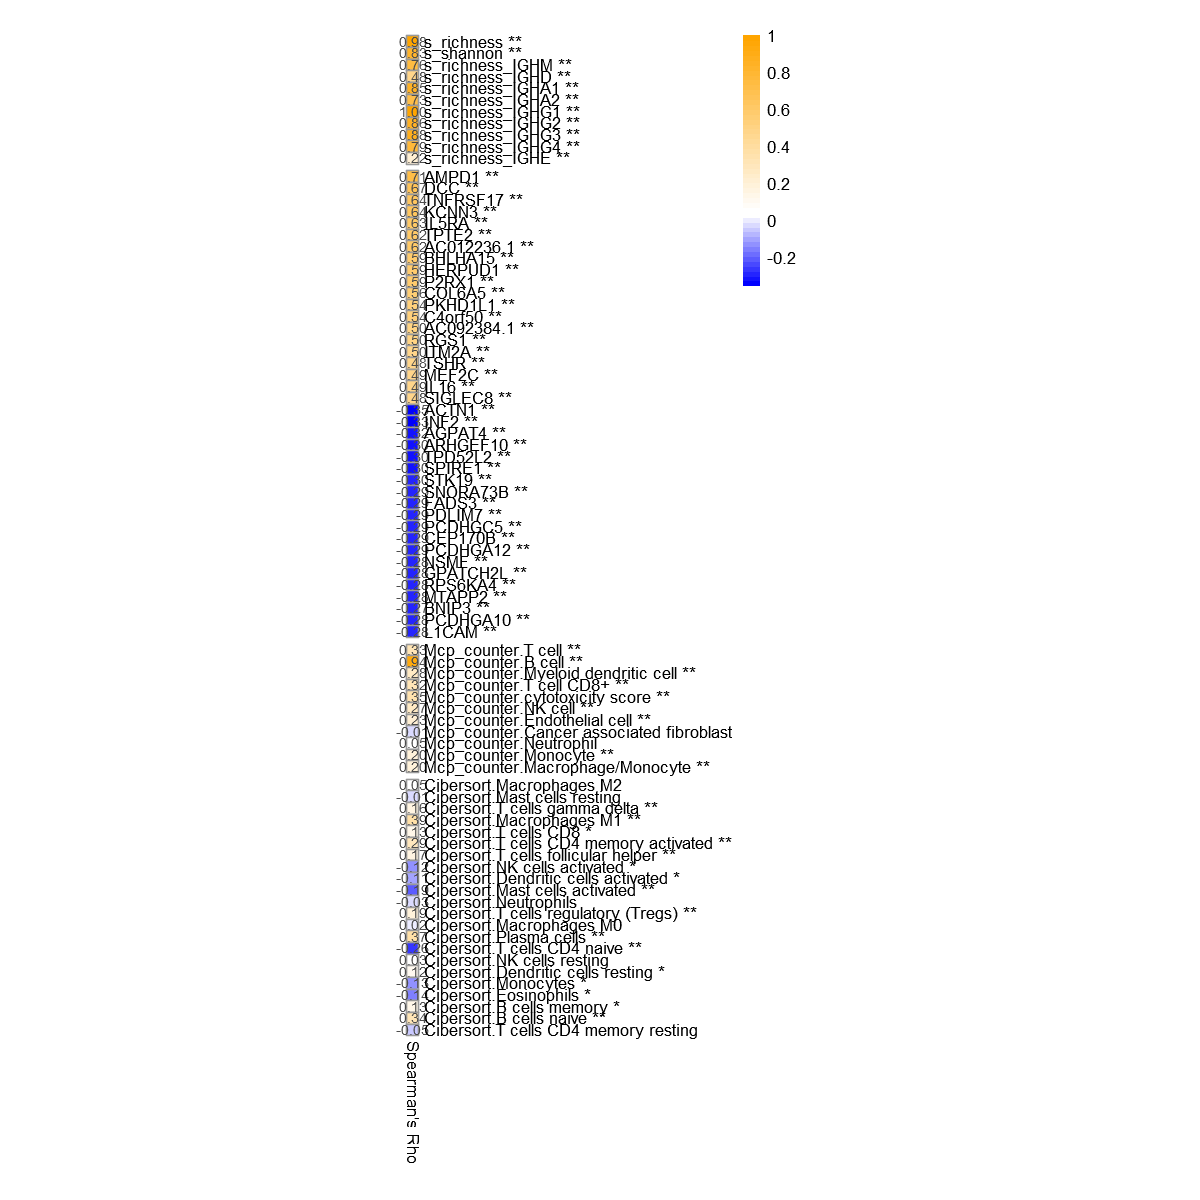

In [37]:
bk <- c(seq(-0.4,-0.01,by=0.01),seq(0,1,by=0.01))
Rho_color = c(colorRampPalette(colors = c("blue","white"))(length(bk)/10),colorRampPalette(colors = c("white","orange"))(length(bk)/4))

options(repr.plot.width = 10, repr.plot.height = 10)

a_IGHG1<-pheatmap(annotation_rows,cluster_rows=FALSE,cluster_cols=FALSE,
          gaps_row=c(gaps_pos1,gaps_pos2,gaps_pos3),cellwidth=7,cellheight =7,
          display_numbers=TRUE,number_format="%.2f",
          color=Rho_color
          )

pdf("IGHG1_cor_heatmap.pdf",10,10)
print(p_IGHG1)
dev.off()

pdf("IGHG1_cor_heatmap_row_annotation.pdf",10,10)
print(a_IGHG1)
dev.off()
